In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt


# Import Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer
from sklearn.feature_selection import chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Import Sampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Import preprocessing libraries     
from sklearn.preprocessing import StandardScaler


# Import model selection libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:

df = pd.read_csv(r'C:\Users\megha\Downloads\project1\data\Cardio_30000.csv', sep=',', quotechar='"')

# Clean up column names if needed
df.columns = [col.strip().replace('"', '') for col in df.columns]

# Check the result
print("Columns in dataset:", df.columns.tolist())
print("Number of rows are: ",df.shape[0])
print("Number of columns are: ",df.shape[1])
print("number of duplicate",df.duplicated().sum())

Columns in dataset: ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
Number of rows are:  308854
Number of columns are:  19
number of duplicate 80


In [3]:
# Binary mapping for Yes/No columns
yes_no_cols = ['Exercise', 'Heart_Disease', 'Skin_Cancer', 
               'Other_Cancer', 'Depression', 'Arthritis', 
               'Smoking_History']
for col in yes_no_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Binary mapping for gender
df['Sex'] = df['Sex'].map({'Female': 1, 'Male': 0})

# Ordinal mapping for General_Health
df['General_Health'] = df['General_Health'].map({
    'Poor': 0, 'Fair': 1, 'Good': 2, 'Very Good': 3, 'Excellent': 4
})

# Ordinal mapping for Checkup frequency
df['Checkup'] = df['Checkup'].map({
    'Never': 0, 
    '5 or more years ago': 1,
    'Within the past 5 years': 2,
    'Within the past 2 years': 3,
    'Within the past year': 4
})


df['Diabetes'] = df['Diabetes'].map({
    'No': 0,
    'No, pre-diabetes or borderline diabetes': 1,
    'Yes, but female told only during pregnancy': 1,
    'Yes': 2
})


# Ordinal mapping for Age_Category
df['Age_Category'] = df['Age_Category'].map({
    '18-24': 0, '25-29': 1, '30-34': 2, '35-39': 3,
    '40-44': 4, '45-49': 5, '50-54': 6, '55-59': 7,
    '60-64': 8, '65-69': 9, '70-74': 10, '75-79': 11, '80+': 12
})

# Final check
print("Columns in dataset:", df.columns.tolist())
print(df.head())
print(df.dtypes)


Columns in dataset: ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
   General_Health  Checkup  Exercise  Heart_Disease  Skin_Cancer  \
0               0        3         0              0            0   
1               3        4         0              1            0   
2               3        4         1              0            0   
3               0        4         1              1            0   
4               2        4         0              0            0   

   Other_Cancer  Depression  Diabetes  Arthritis  Sex  Age_Category  \
0             0           0         0          1    1            10   
1             0           0         2          0    1            10   
2             0           0         2          

Remove any repeatative or duplicate rows

In [4]:
df[df.duplicated()]
df[df.duplicated(keep=False)]
df = df.drop_duplicates()

In [5]:
df.duplicated().sum()

np.int64(0)

### Synthetic Dataset 

In [6]:
vaccine_types = ['Pfizer', 'Moderna', 'AstraZeneca']
df['vaccinated'] = np.random.choice([0, 1], size=len(df), p=[0.2, 0.8])
df['dose_number'] = 0
df.loc[df['vaccinated'] == 1, 'dose_number'] = np.random.choice([1, 2, 3], size=(df['vaccinated'] == 1).sum())
df['vaccine_type'] = np.where(df['vaccinated'] == 1, 
                              np.random.choice(vaccine_types, size=len(df)), 
                              'None')
df['days_since_vaccination'] = np.where(df['vaccinated'] == 1,
                                        np.random.randint(0, 366, size=len(df)),
                                        0)

# --- COVID Infection ---
df['covid_infection'] = np.random.choice([0, 1], size=len(df), p=[0.7, 0.3])
severity_levels = ['None', 'Mild', 'Moderate', 'Severe']
df['covid_infection_severity'] = np.where(df['covid_infection'] == 1,
    np.random.choice(severity_levels[1:], size=len(df)), 'None')
df['long_covid_symptoms'] = np.where(df['covid_infection'] == 1,
    np.random.choice([0, 1], size=len(df), p=[0.75, 0.25]), 0)

# --- Myocarditis Logic ---
df['myocarditis_diagnosed'] = 0
df['myocarditis_onset'] = 'None'
df['myocarditis_recovered'] = 0

recent_vax = df['days_since_vaccination'] <= 28
male_16_30 = (df['Sex'] == 0) & (df['Age_Category'] <= 3)

# Vaccine-related myocarditis
for vaccine, prob in [('Moderna', 0.005), ('Pfizer', 0.003), ('AstraZeneca', 0.0005)]:
    vax_mask = (df['vaccine_type'] == vaccine) & (df['dose_number'] == 2) & recent_vax & male_16_30
    df.loc[vax_mask, 'myocarditis_diagnosed'] = np.random.binomial(1, prob, size=vax_mask.sum())

# Dose 3 (booster) lower risk
booster_mask = (df['dose_number'] == 3) & recent_vax
df.loc[booster_mask, 'myocarditis_diagnosed'] = np.random.binomial(1, 0.001, size=booster_mask.sum())

# Post-COVID myocarditis (if not already diagnosed)
post_covid_mask = (df['covid_infection'] == 1) & (df['myocarditis_diagnosed'] == 0)
df.loc[post_covid_mask, 'myocarditis_diagnosed'] = np.random.binomial(1, 0.02, size=post_covid_mask.sum())

# --- Myocarditis onset & recovery ---
df['myocarditis_onset'] = np.where(
    (df['myocarditis_diagnosed'] == 1) & (df['covid_infection'] == 1),
    'Post-COVID',
    df['myocarditis_onset']
)
df['myocarditis_onset'] = np.where(
    (df['myocarditis_diagnosed'] == 1) & recent_vax,
    'Post-vaccine',
    df['myocarditis_onset']
)

df.loc[df['myocarditis_onset'] == 'Post-COVID', 'myocarditis_recovered'] = np.random.choice([0, 1], size=(df['myocarditis_onset'] == 'Post-COVID').sum(), p=[0.4, 0.6])
df.loc[df['myocarditis_onset'] == 'Post-vaccine', 'myocarditis_recovered'] = np.random.choice([0, 1], size=(df['myocarditis_onset'] == 'Post-vaccine').sum(), p=[0.1, 0.9])

# --- Heart Disease (cardio) Risk Logic ---
df['cardio'] = 0

# 1. Myocarditis → 40% risk
mask_myo = df['myocarditis_diagnosed'] == 1
df.loc[mask_myo, 'cardio'] = np.random.binomial(1, 0.4, size=mask_myo.sum())

# 2. Long COVID → +30% risk
mask_lc = (df['long_covid_symptoms'] == 1) & (df['cardio'] == 0)
df.loc[mask_lc, 'cardio'] = np.random.binomial(1, 0.3, size=mask_lc.sum())

# 4. General population base risk → 20%
mask_base = df['cardio'] == 0
df.loc[mask_base, 'cardio'] = np.random.binomial(1, 0.2, size=mask_base.sum())

In [7]:
vaccines = ['vaccine_type']

for col in vaccines:
    df[col] = df[col].map({'None':0,'AstraZeneca': 1, 'Moderna': 2, 'Pfizer': 3})

Covid_infection = ['covid_infection_severity']
for col in Covid_infection:
    df[col] = df[col].map({'None':0,'Mild':1,'Moderate':2,'Severe':3})

myocarditis = ['myocarditis_onset']

for col in myocarditis:
    df[col] = df[col].map({'None':0,'Post-COVID':1,'Post-vaccine':2})

If a person is older, has a high BMI and poor general health, and doesn't exercise → higher CHD risk.



In [8]:
# Step 1: Create 'obesity_level' using integers instead of strings (cleaner)
def obesity_level(row):
    obese = row['BMI'] >= 30
    age = row['Age_Category']
    if obese and age >= 5:
        return 3
    elif obese and age >= 2:
        return 2
    elif obese:
        return 1
    else:
        return 0

df['obesity_level'] = df.apply(obesity_level, axis=1)

# Step 2: Update CHD_risk to 1 only when conditions are met (leave others unchanged)
df.loc[(df['obesity_level'].isin([2, 3])) & (df['Exercise'] == 0), 'Heart_Disease'] = 1


In [9]:
# Create combined target: 1 if either Heart_Disease or cardio is 1, else 0
df['CHD_Risk'] = ((df['Heart_Disease'] == 1) | (df['cardio'] == 1)).astype(int)

# Check the distribution
print(df['CHD_Risk'].value_counts())
print(df['cardio'].value_counts())


CHD_Risk
0    201030
1    107744
Name: count, dtype: int64
cardio
0    240665
1     68109
Name: count, dtype: int64


In [10]:
print("Columns in dataset:", df.columns.tolist())
print(df.head())
print(df.dtypes)

Columns in dataset: ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 'vaccinated', 'dose_number', 'vaccine_type', 'days_since_vaccination', 'covid_infection', 'covid_infection_severity', 'long_covid_symptoms', 'myocarditis_diagnosed', 'myocarditis_onset', 'myocarditis_recovered', 'cardio', 'obesity_level', 'CHD_Risk']
   General_Health  Checkup  Exercise  Heart_Disease  Skin_Cancer  \
0               0        3         0              0            0   
1               3        4         0              1            0   
2               3        4         1              0            0   
3               0        4         1              1            0   
4               2        4         0              0            0   

   Other_

## Finding out the best dependable featues

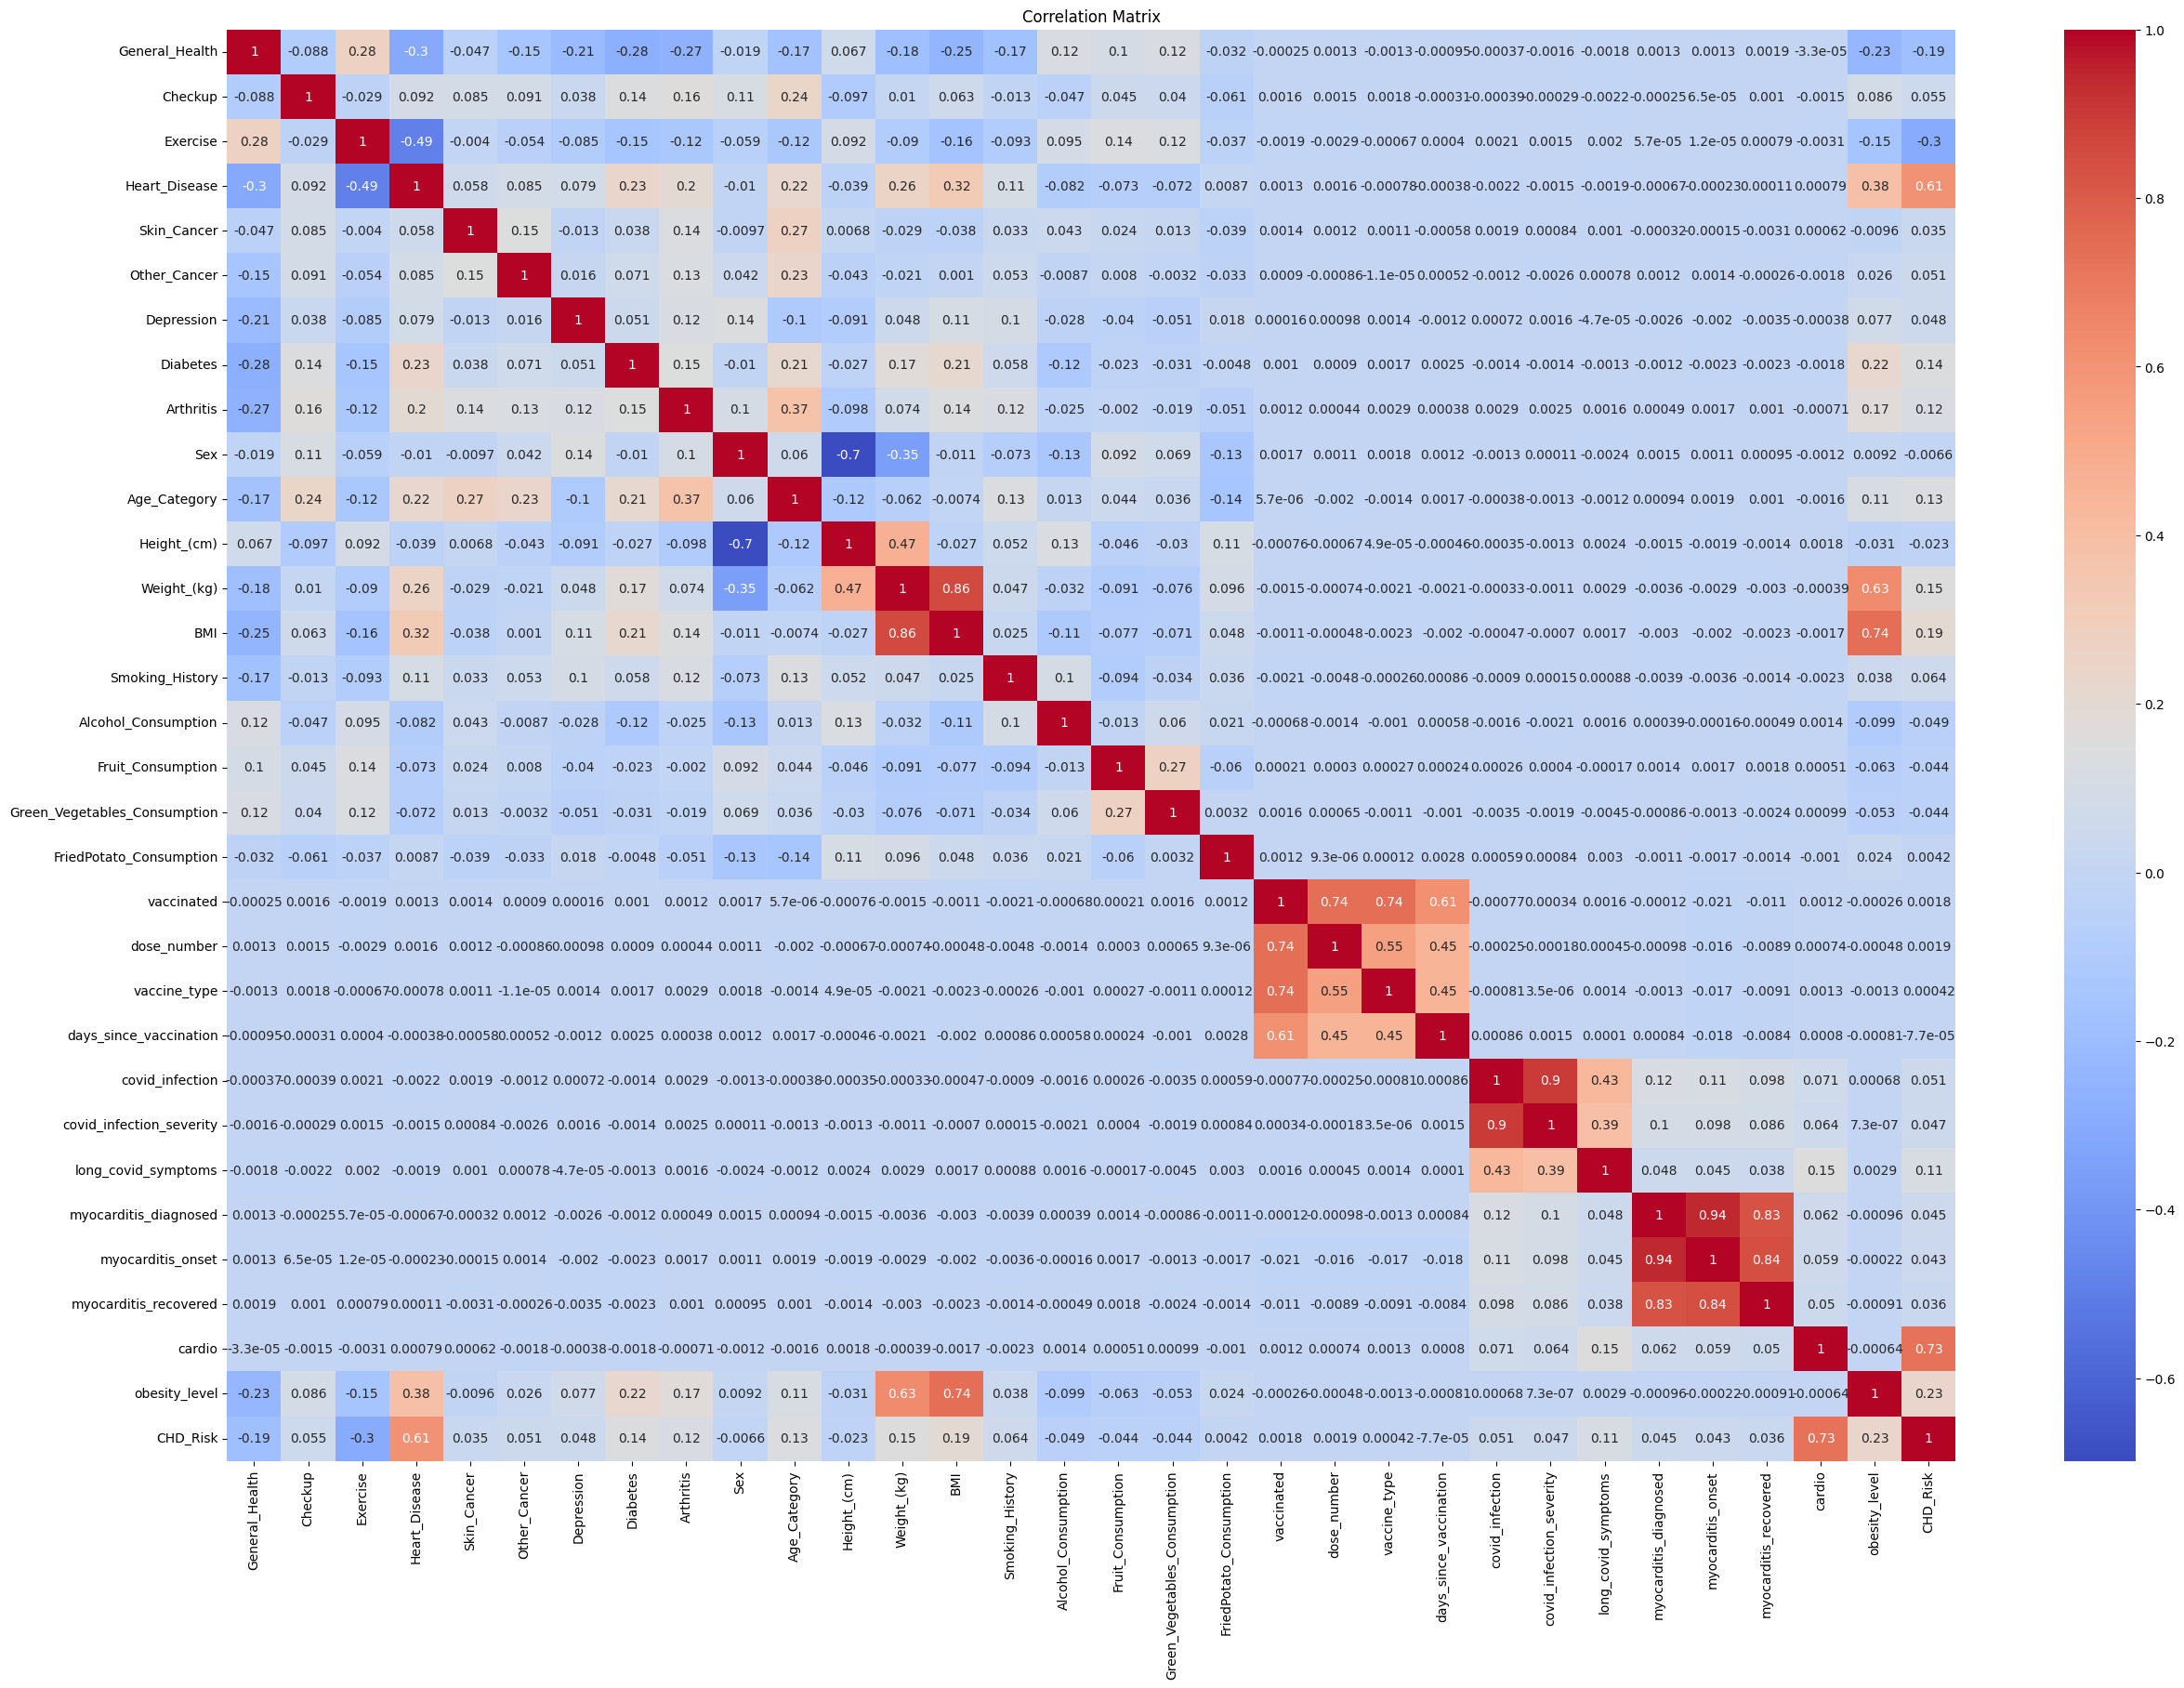

CHD_Risk                        1.000000
cardio                          0.726657
Heart_Disease                   0.606861
obesity_level                   0.232240
BMI                             0.191151
Weight_(kg)                     0.154347
Diabetes                        0.140427
Age_Category                    0.132526
Arthritis                       0.118248
long_covid_symptoms             0.111893
Smoking_History                 0.063645
Checkup                         0.054811
covid_infection                 0.051171
Other_Cancer                    0.051017
Depression                      0.047621
covid_infection_severity        0.046805
myocarditis_diagnosed           0.045391
myocarditis_onset               0.042835
myocarditis_recovered           0.036271
Skin_Cancer                     0.034842
FriedPotato_Consumption         0.004153
dose_number                     0.001876
vaccinated                      0.001823
vaccine_type                    0.000416
days_since_vacci

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr = df.corr()

# Visualize correlation with heatmap
plt.figure(figsize=(30,20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Correlation of all features with the target
print(corr['CHD_Risk'].sort_values(ascending=False))


In [12]:
feature_columns = ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 'vaccinated', 'dose_number', 'vaccine_type', 'days_since_vaccination', 'covid_infection', 'covid_infection_severity', 'long_covid_symptoms', 'myocarditis_diagnosed', 'myocarditis_onset', 'myocarditis_recovered', 'cardio', 'obesity_level', 'CHD_Risk']

In [13]:

# Standardize features (important for VIF stability)
X_scaled = StandardScaler().fit_transform(df[feature_columns])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = feature_columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data)


                         feature        VIF
0                 General_Health   1.343874
1                        Checkup   1.098447
2                       Exercise   1.398430
3                  Heart_Disease   5.128170
4                    Skin_Cancer   1.099397
5                   Other_Cancer   1.084308
6                     Depression   1.123988
7                       Diabetes   1.179683
8                      Arthritis   1.270345
9                            Sex   2.053570
10                  Age_Category   1.508129
11                   Height_(cm)  18.816861
12                   Weight_(kg)  67.466398
13                           BMI  52.684113
14               Smoking_History   1.087194
15           Alcohol_Consumption   1.072515
16             Fruit_Consumption   1.116565
17  Green_Vegetables_Consumption   1.107080
18       FriedPotato_Consumption   1.048210
19                    vaccinated   3.991964
20                   dose_number   2.198342
21                  vaccine_type

# Data Visualisation

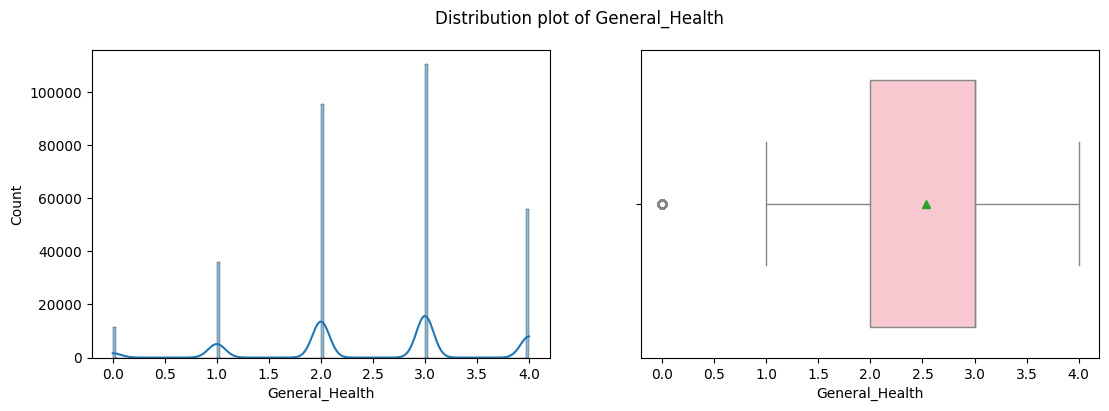

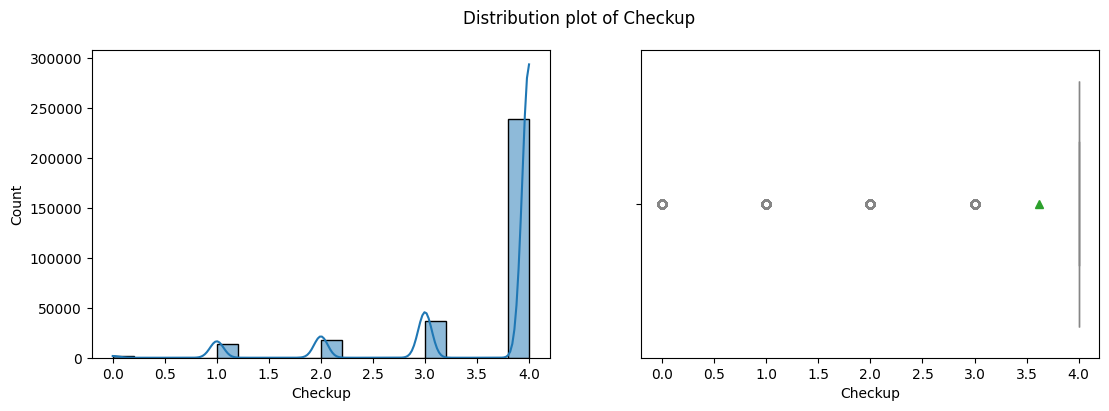

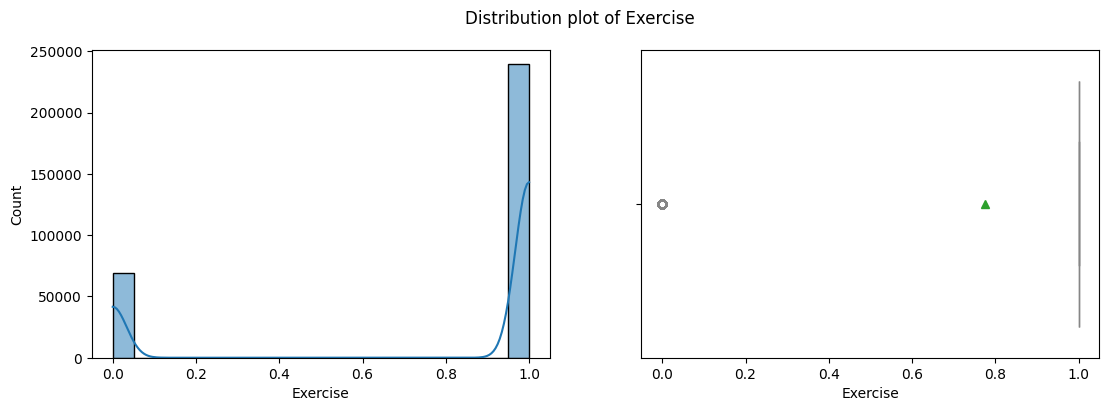

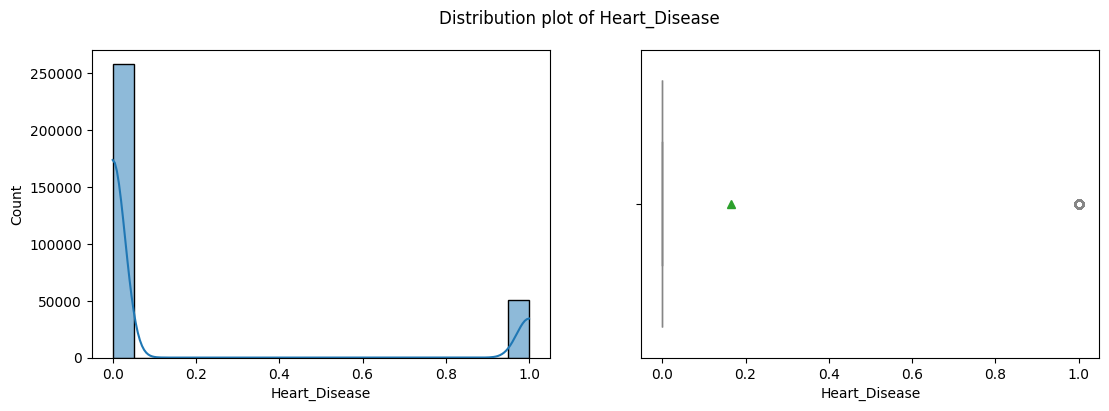

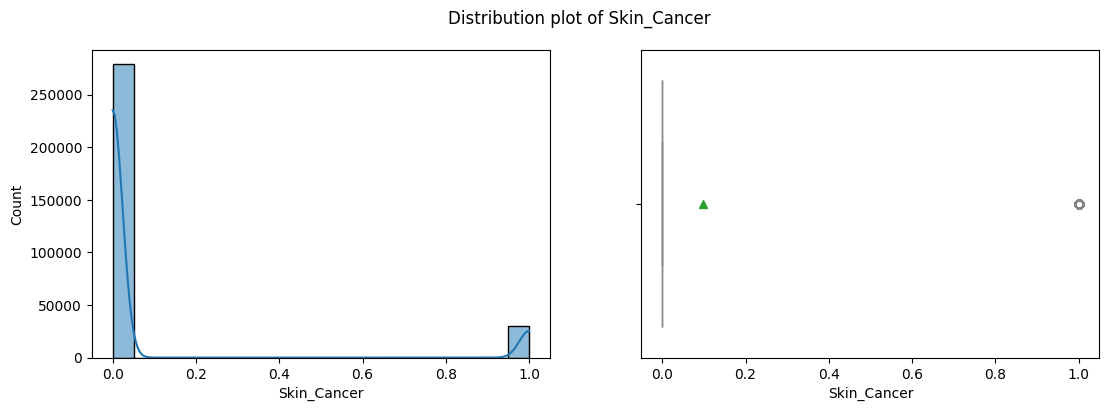

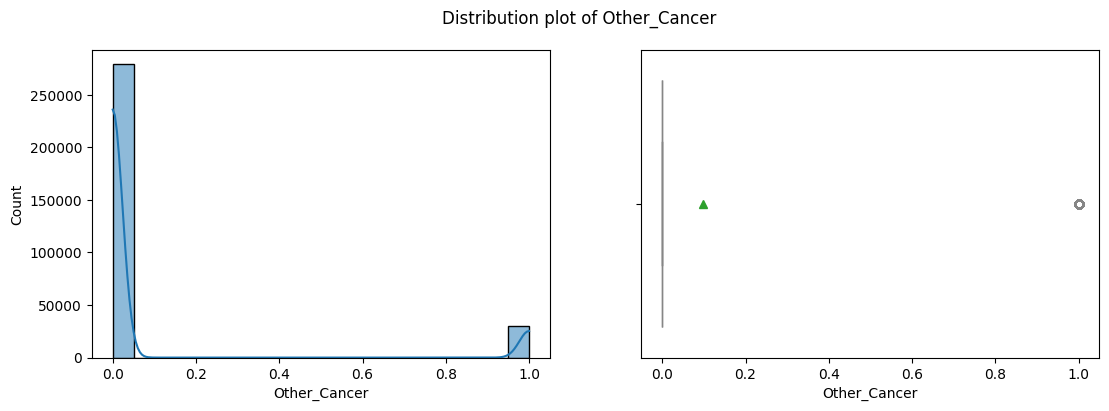

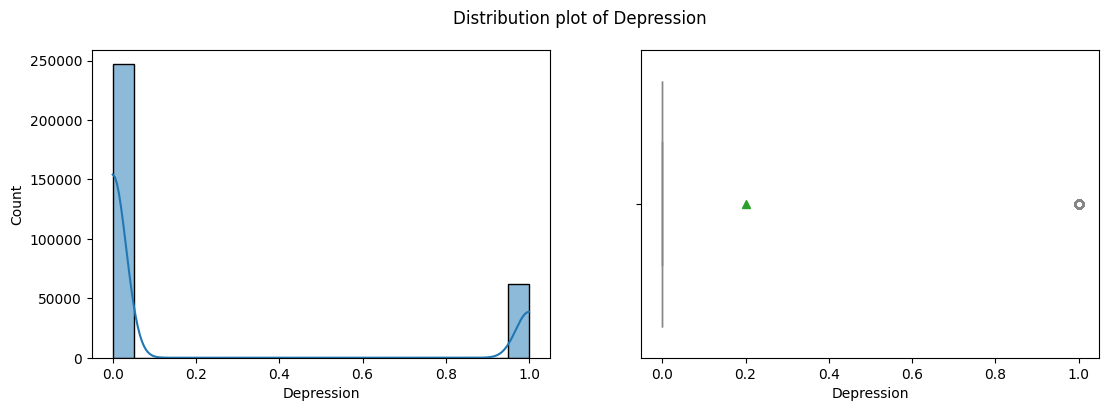

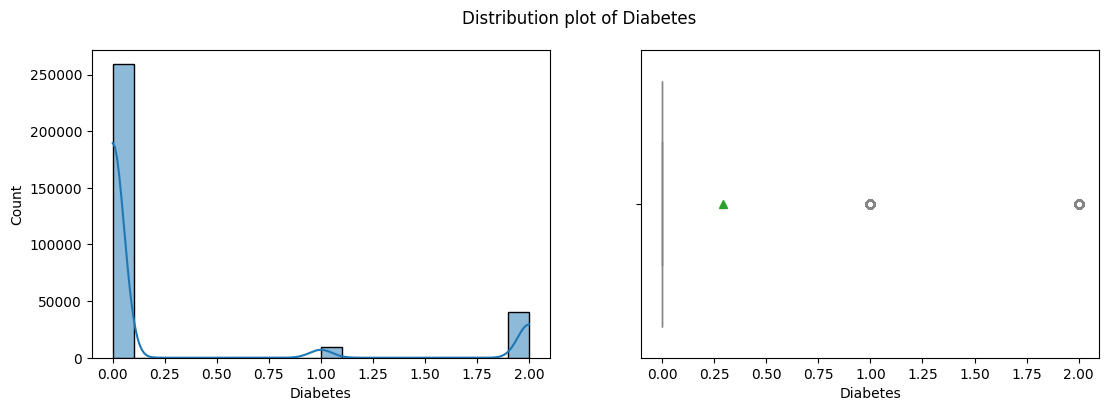

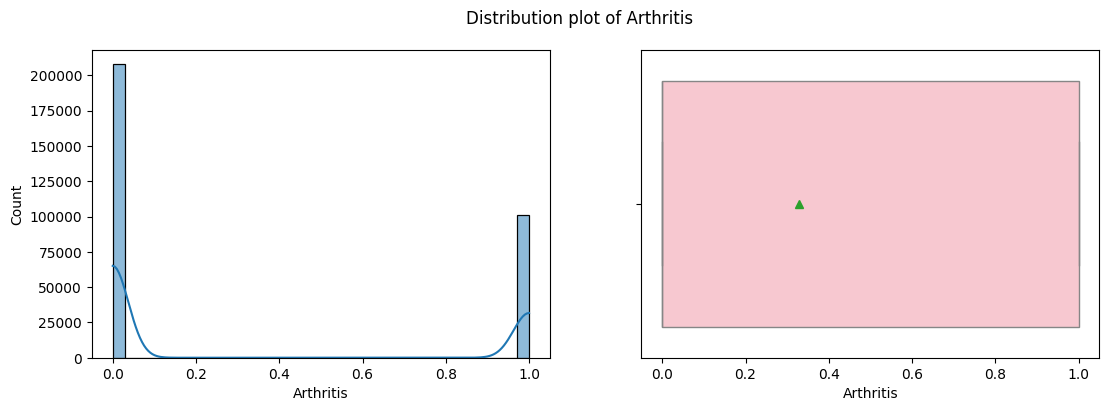

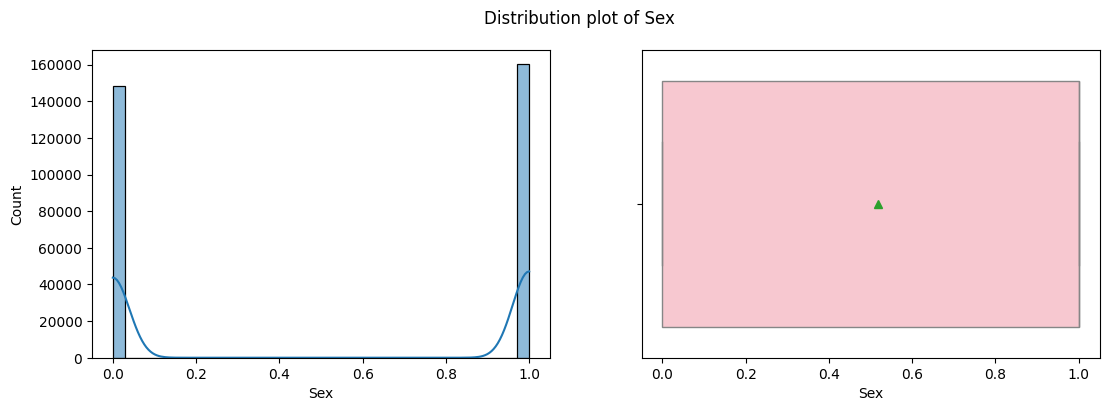

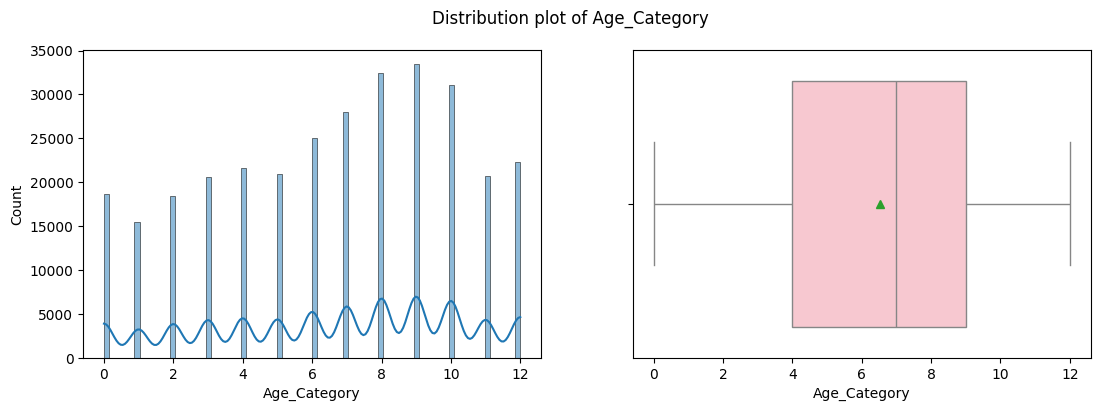

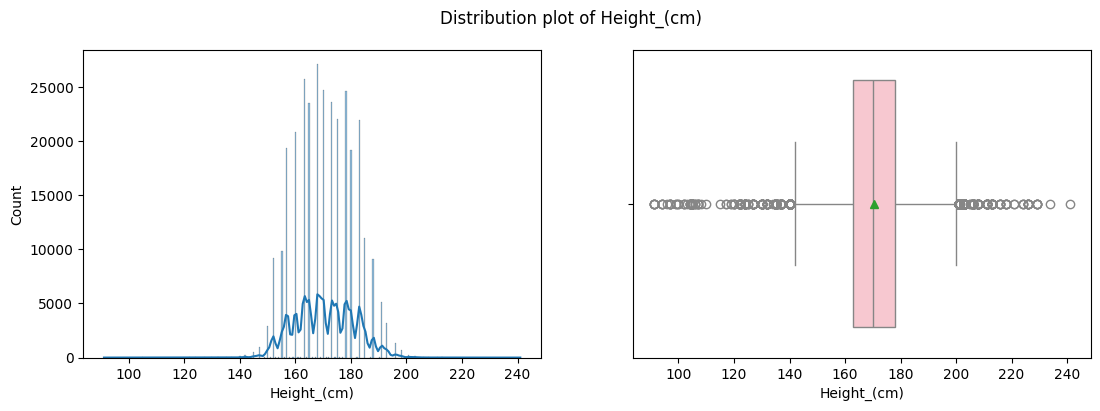

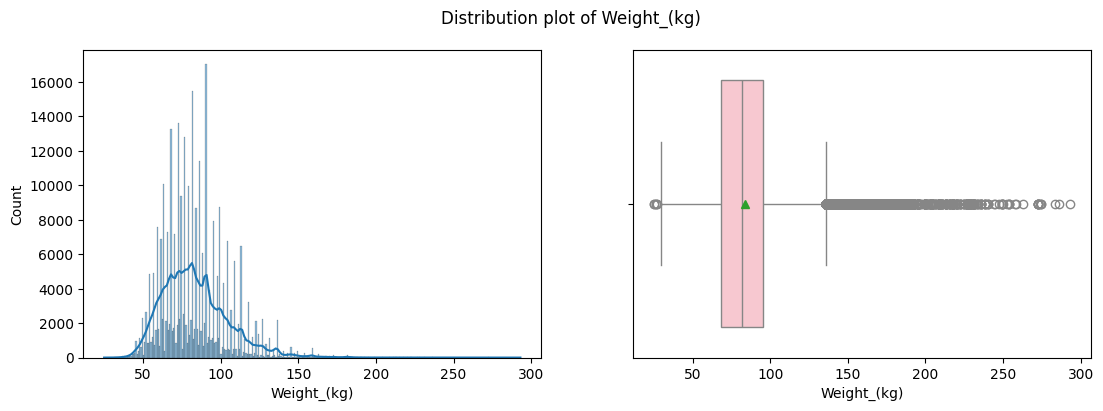

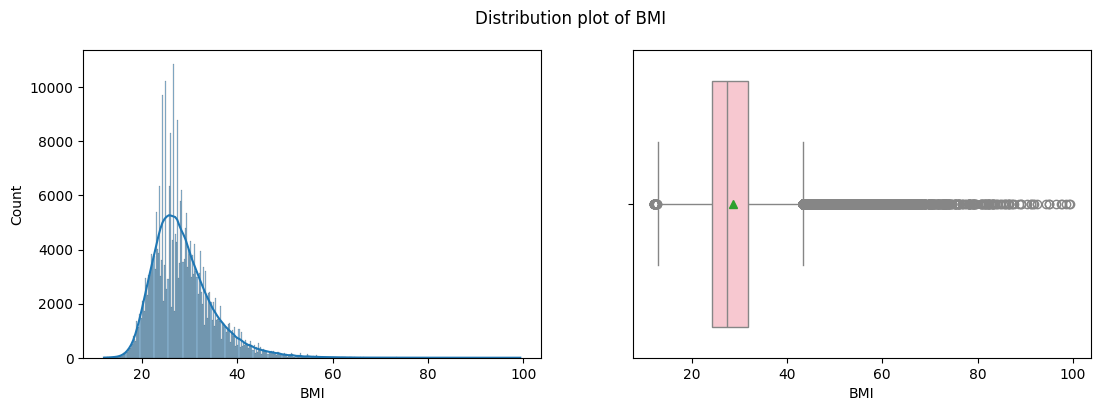

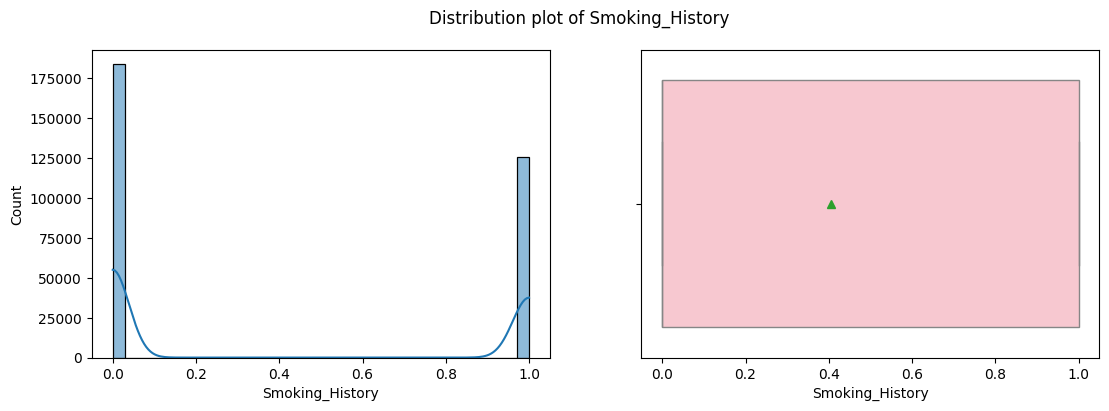

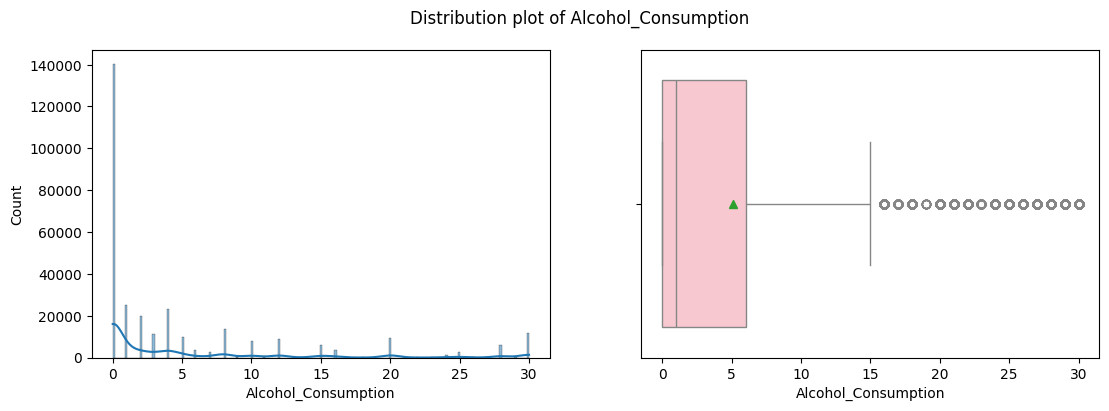

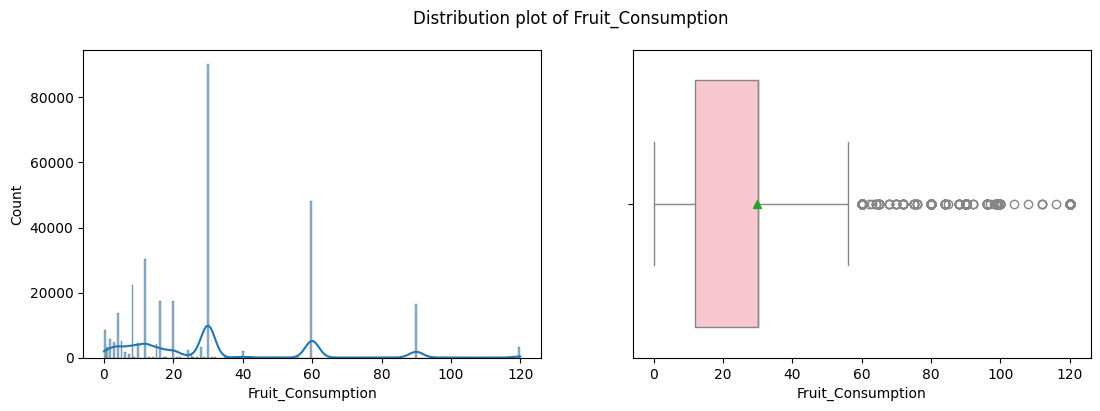

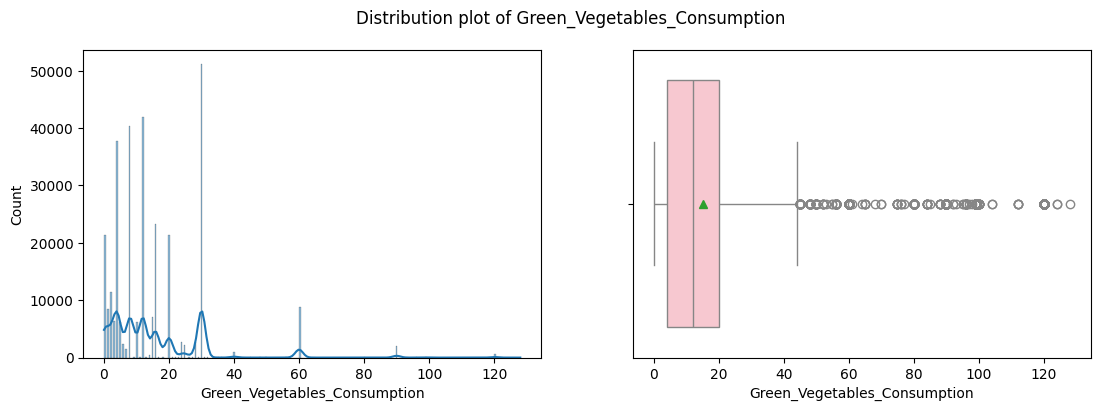

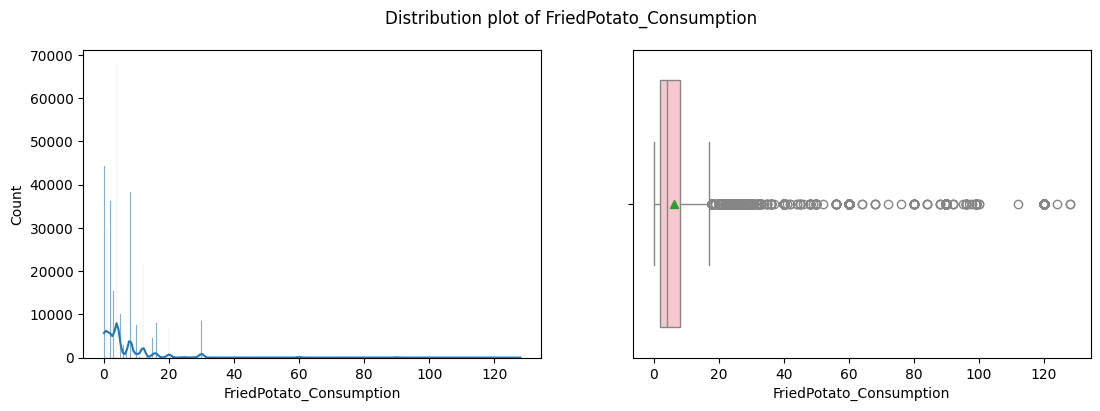

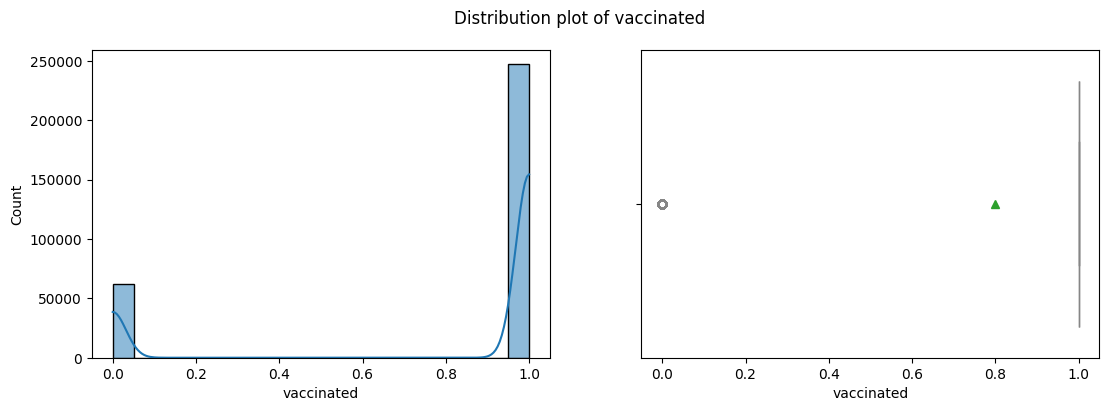

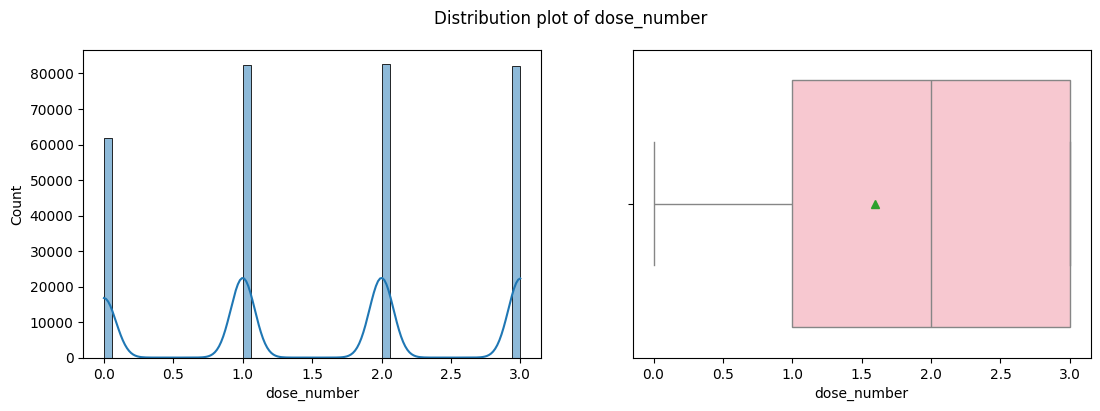

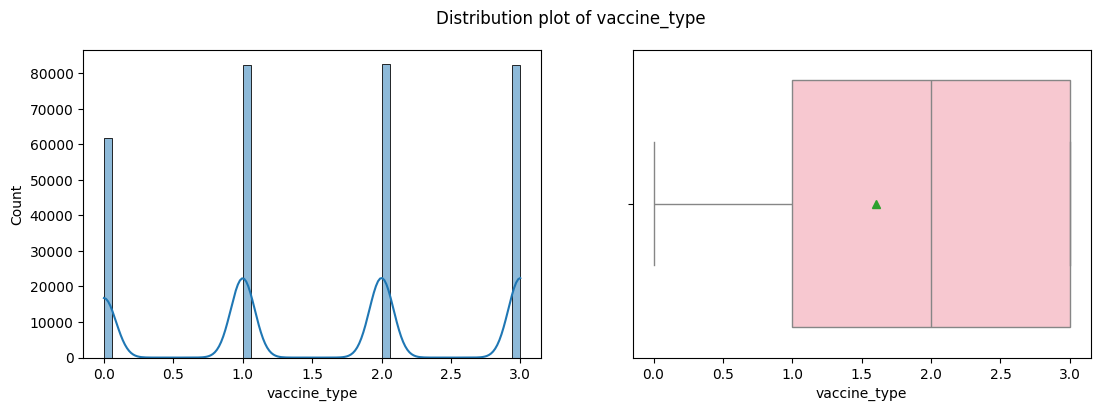

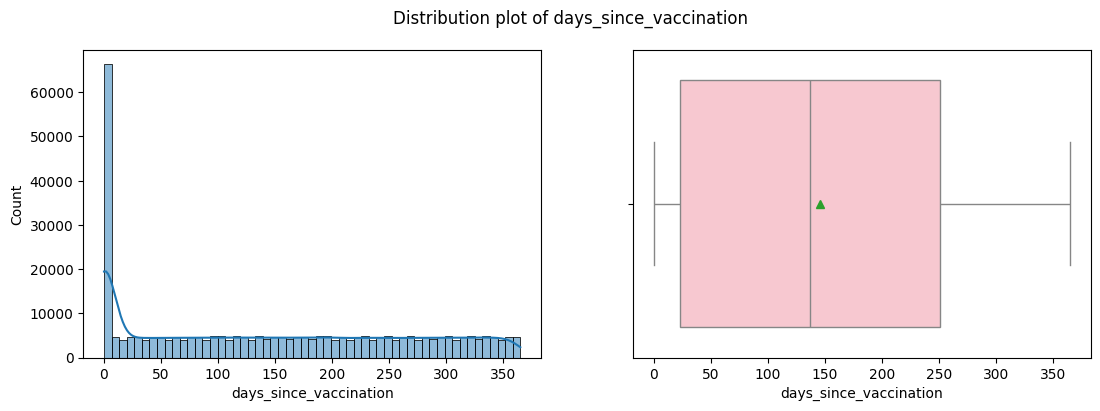

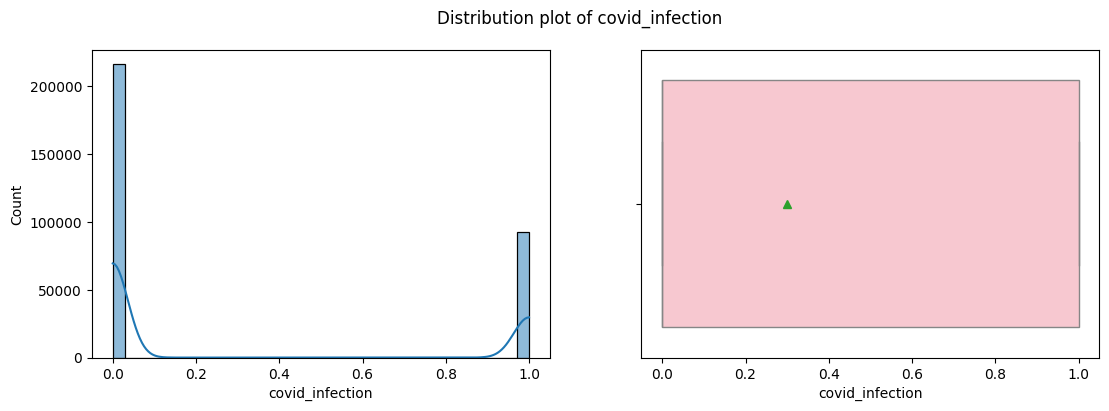

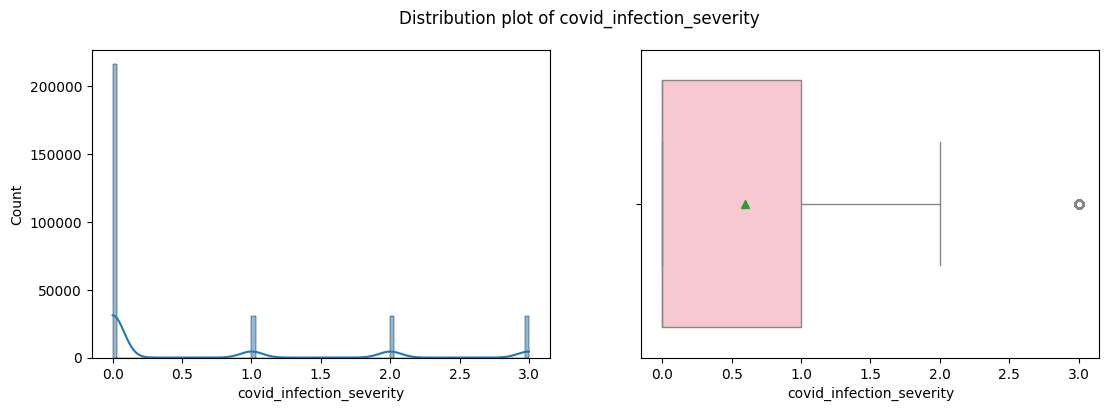

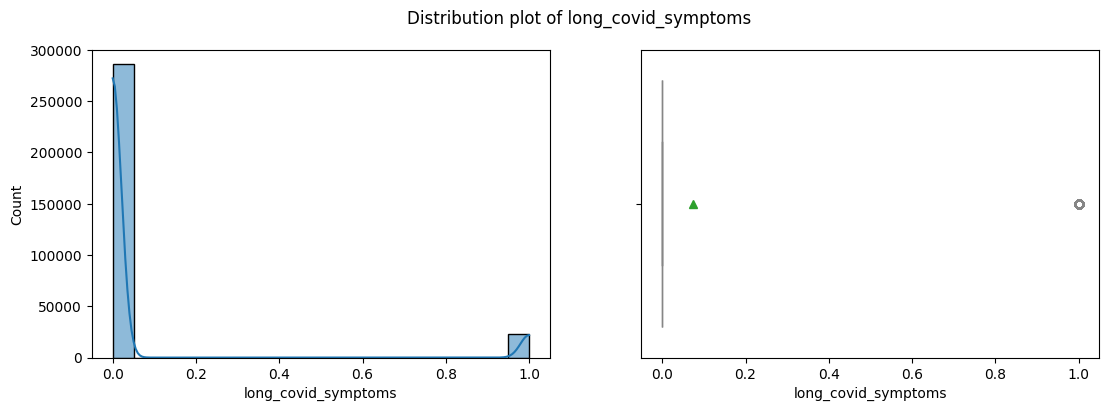

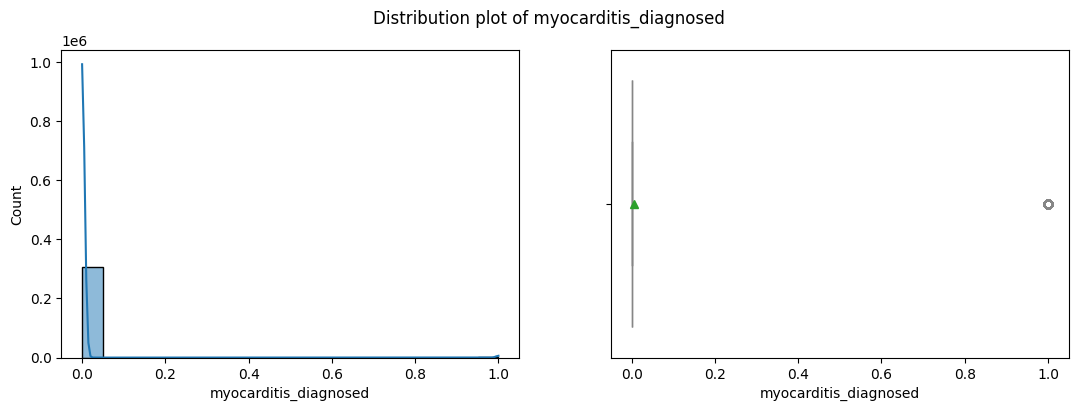

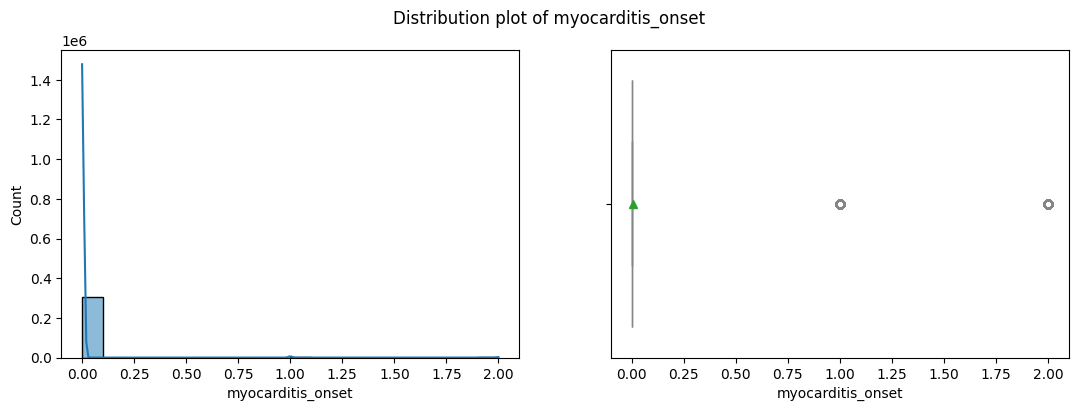

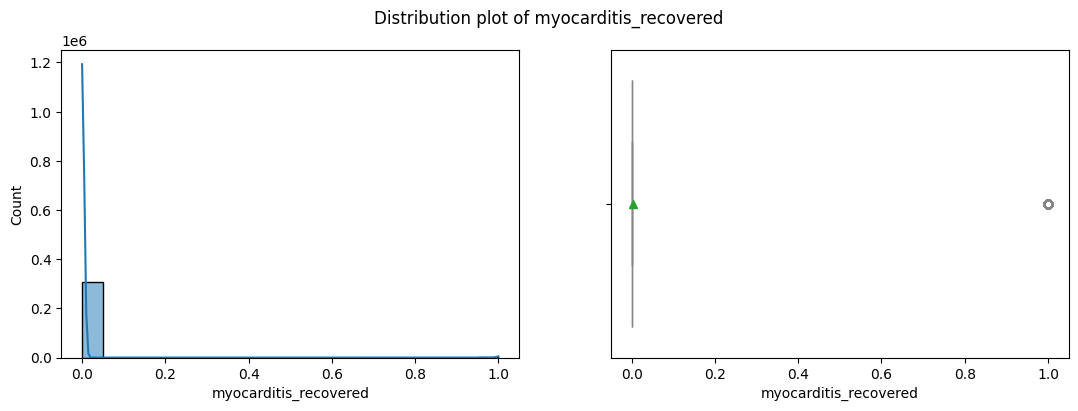

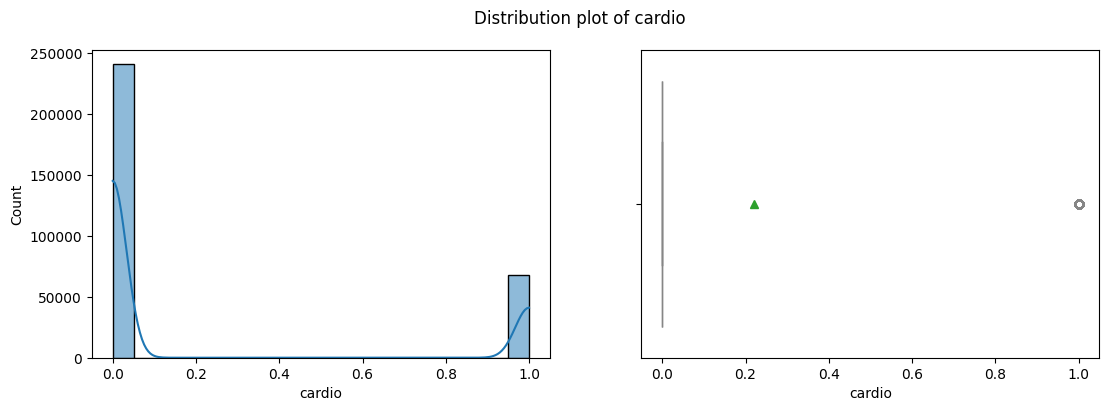

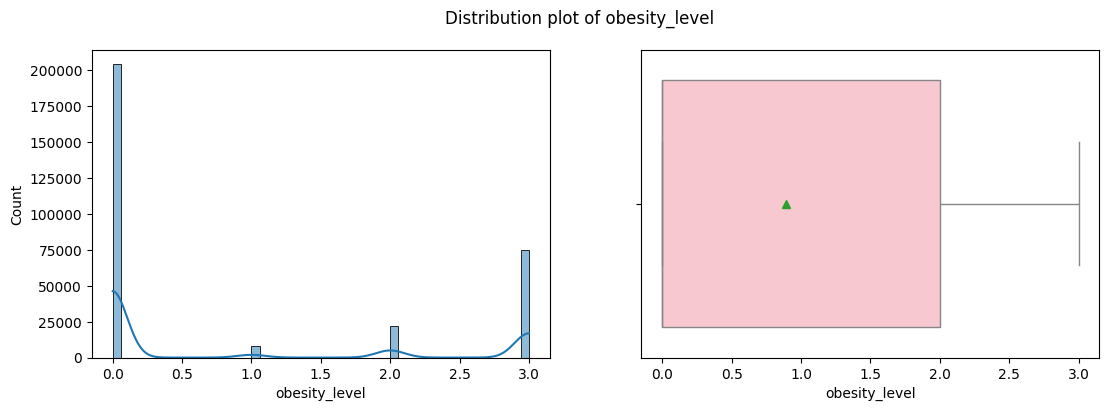

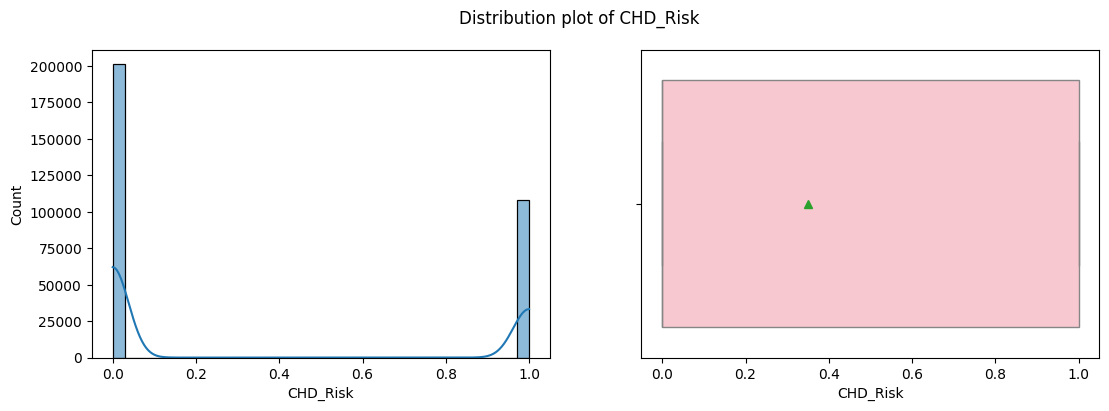

In [14]:
# Chart - 1 visualization code
# Visualizing code of histogram plot & boxplot for each columns to know the data distribution
for col in df.describe().columns:
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(13,4))
    sns.histplot(df[col], ax = axes[0],kde = True)
    sns.boxplot(df[col], ax = axes[1],orient='h',showmeans=True,color='pink')
    fig.suptitle("Distribution plot of "+ col, fontsize = 12)
    plt.show()

In [15]:
dependent_var = ['CHD_Risk']
categorical_var = [i for i in df.columns if df[i].nunique()<=4]
continuous_var = [i for i in df.columns if i not in categorical_var]

In [16]:
categorical_var

['Exercise',
 'Heart_Disease',
 'Skin_Cancer',
 'Other_Cancer',
 'Depression',
 'Diabetes',
 'Arthritis',
 'Sex',
 'Smoking_History',
 'vaccinated',
 'dose_number',
 'vaccine_type',
 'covid_infection',
 'covid_infection_severity',
 'long_covid_symptoms',
 'myocarditis_diagnosed',
 'myocarditis_onset',
 'myocarditis_recovered',
 'cardio',
 'obesity_level',
 'CHD_Risk']

In [17]:
continuous_var

['General_Health',
 'Checkup',
 'Age_Category',
 'Height_(cm)',
 'Weight_(kg)',
 'BMI',
 'Alcohol_Consumption',
 'Fruit_Consumption',
 'Green_Vegetables_Consumption',
 'FriedPotato_Consumption',
 'days_since_vaccination']

### Analysing the distribution of categorical variables in the dataset


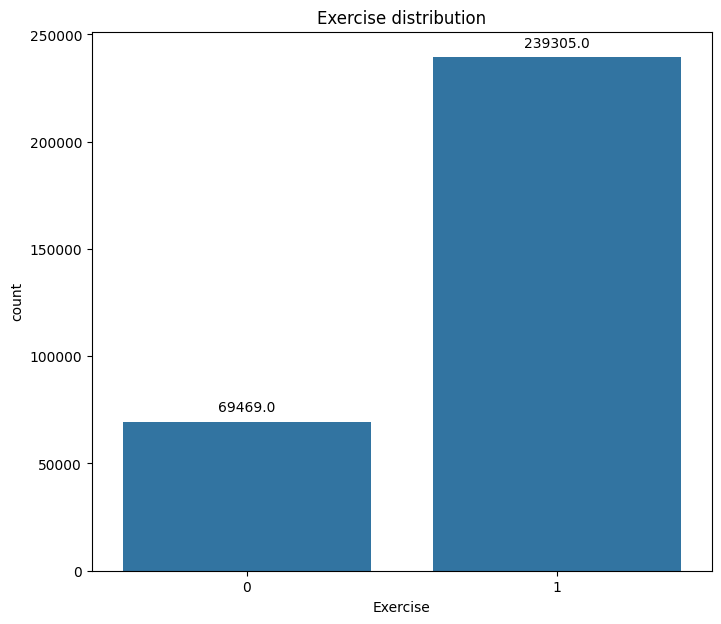

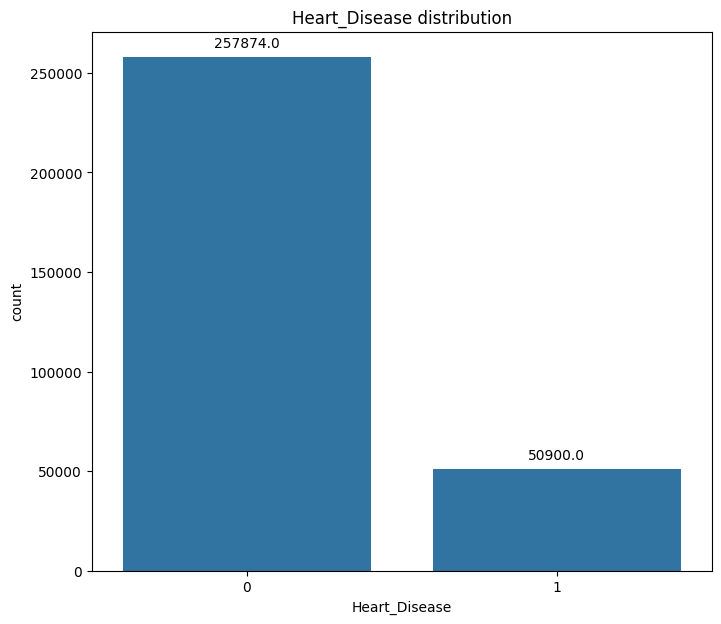

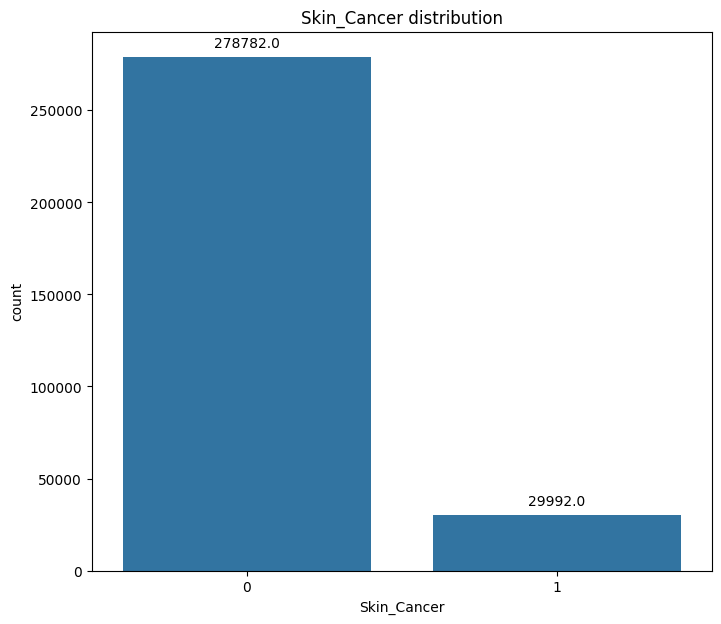

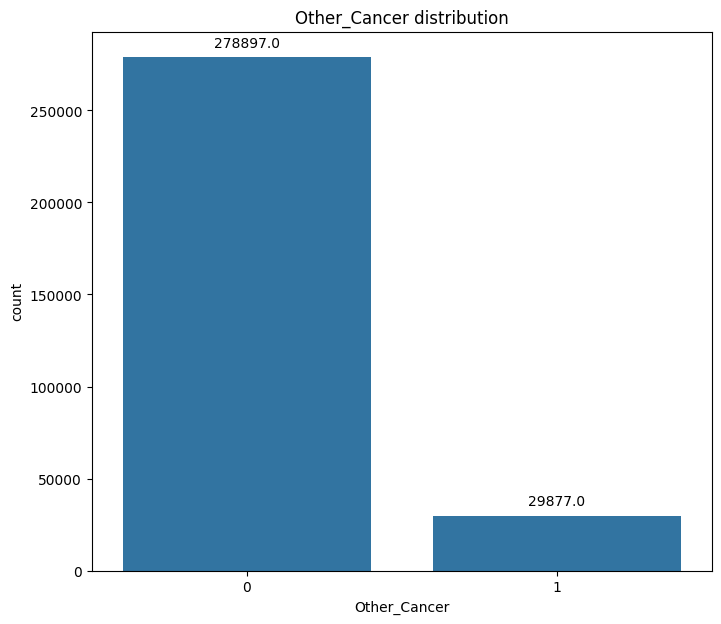

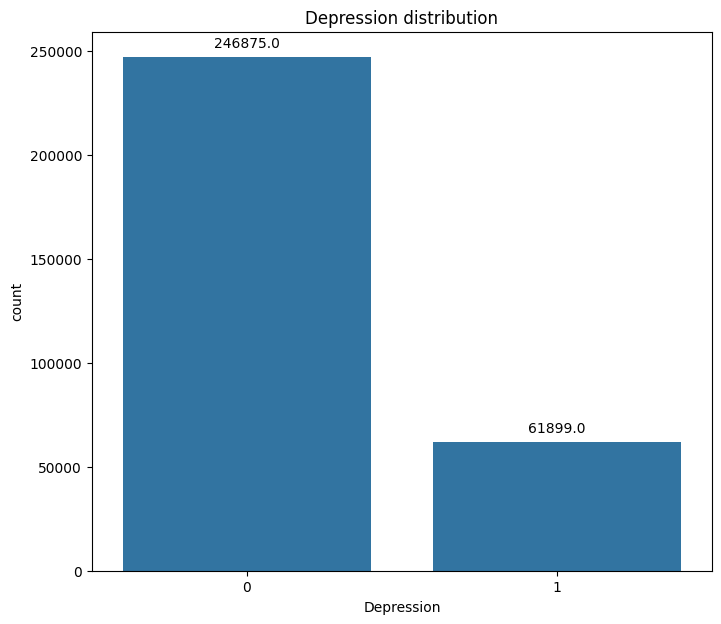

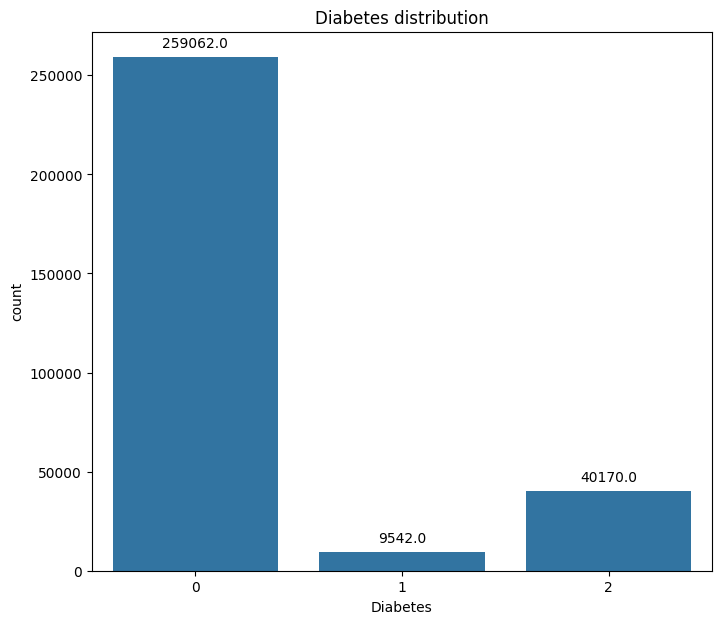

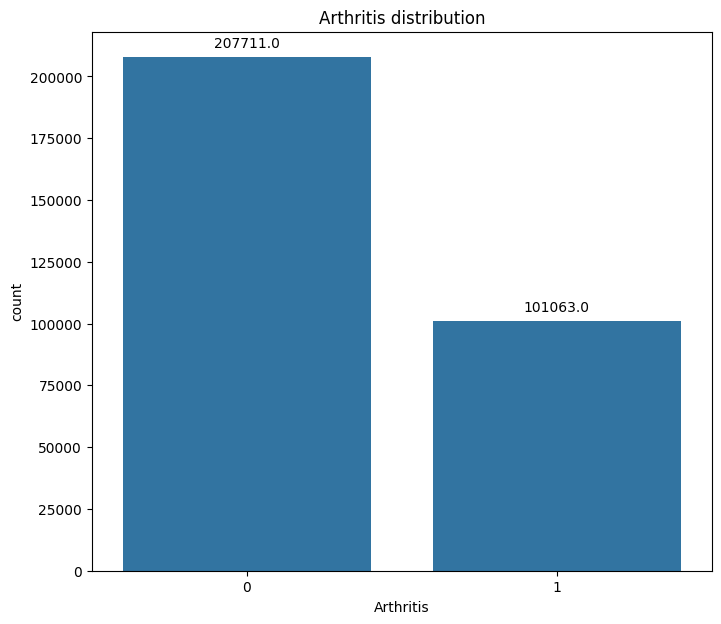

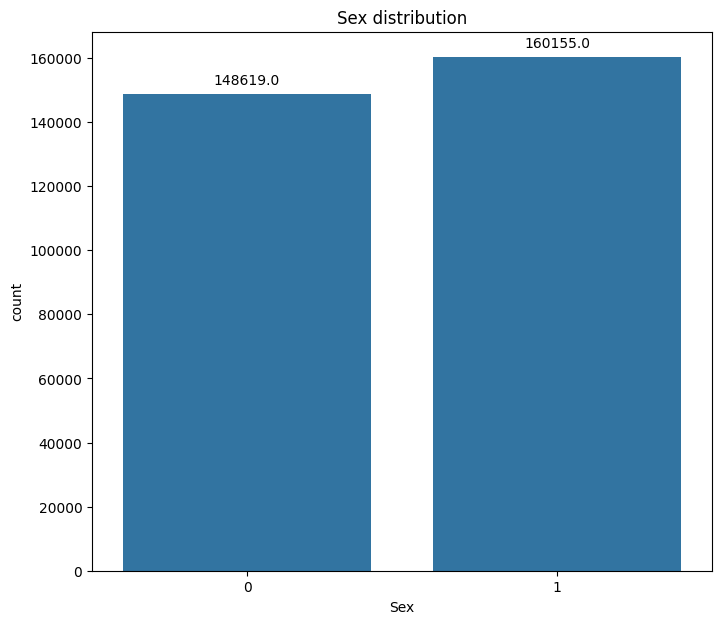

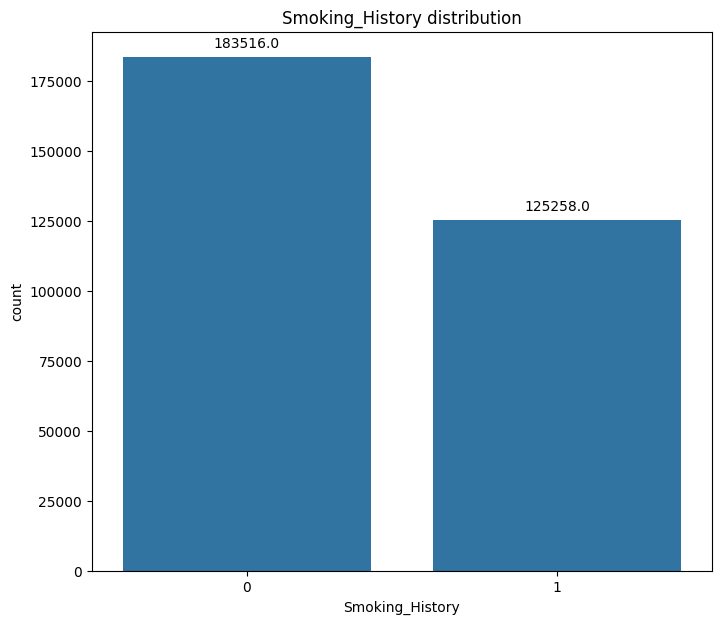

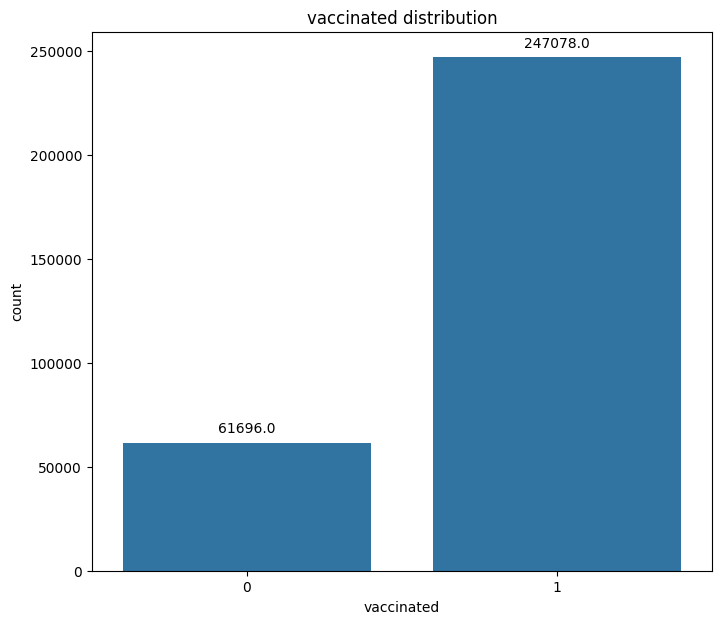

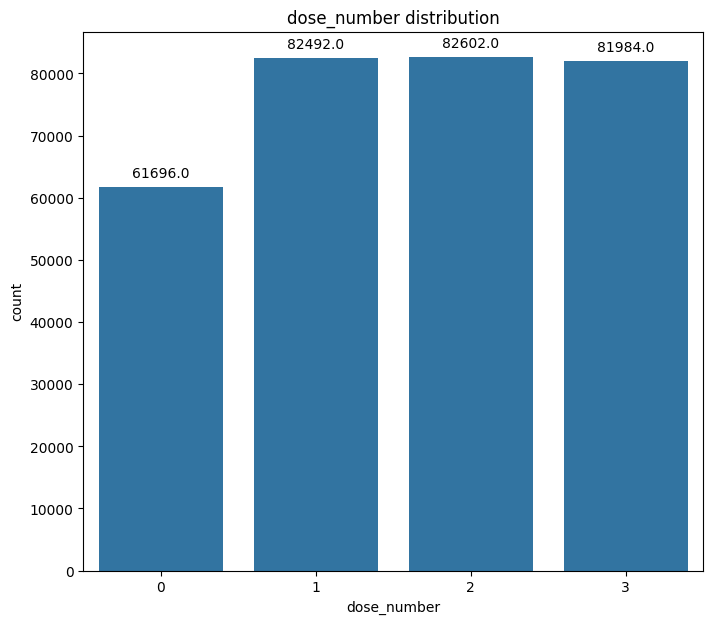

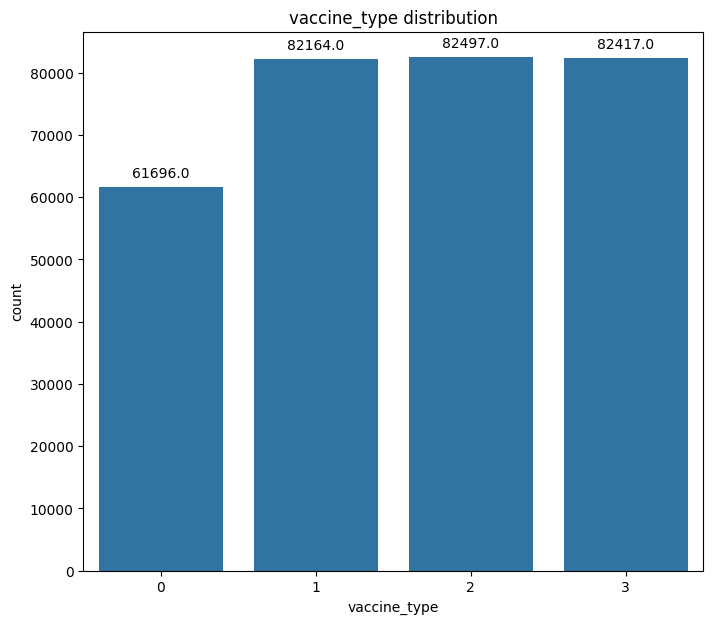

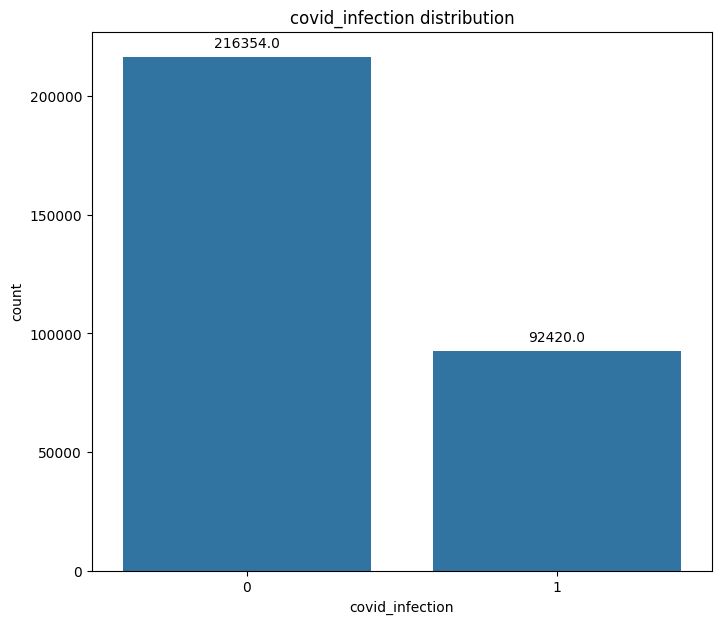

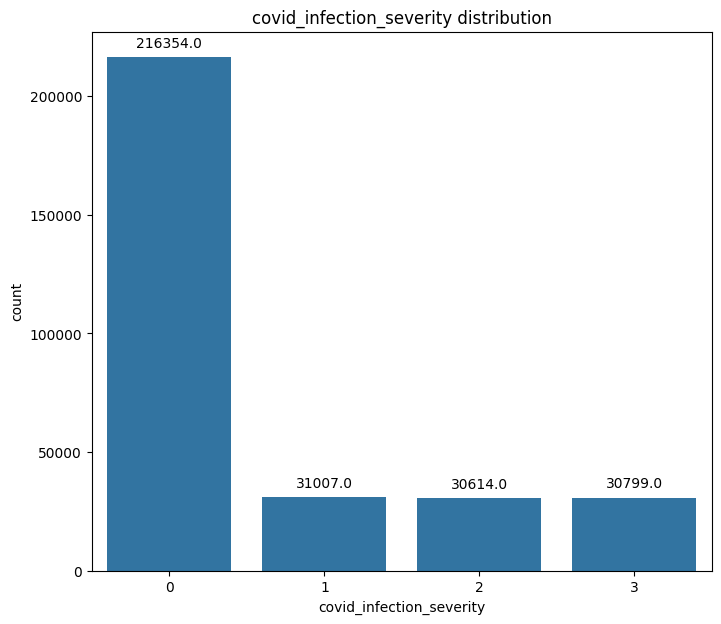

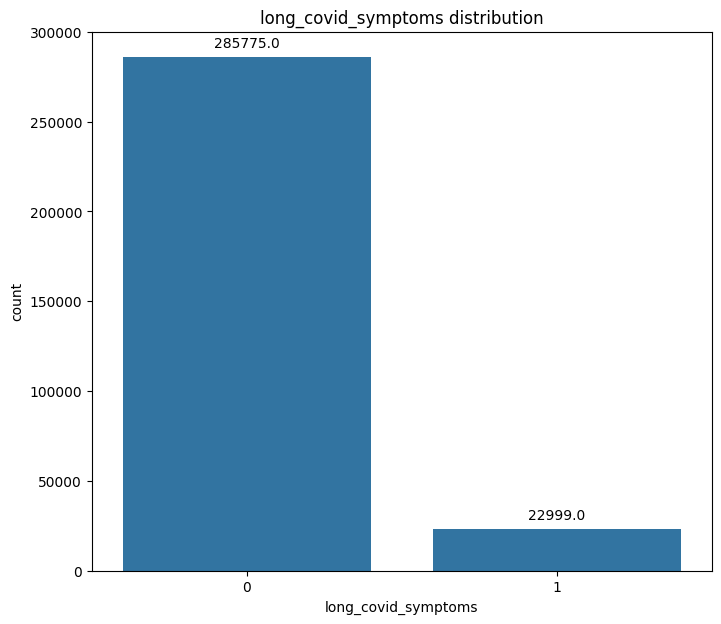

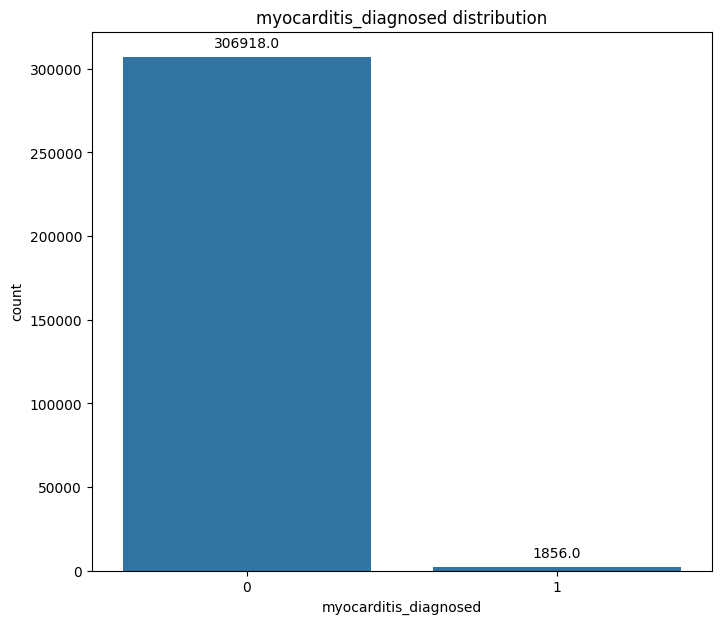

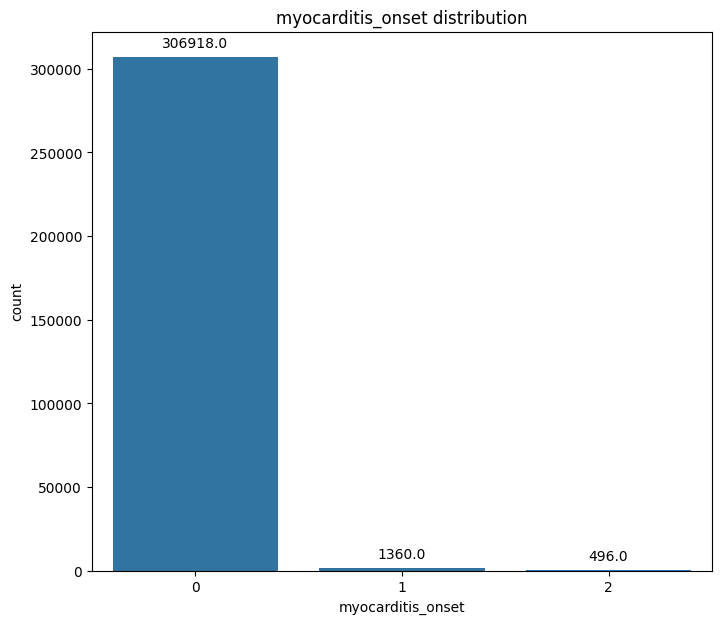

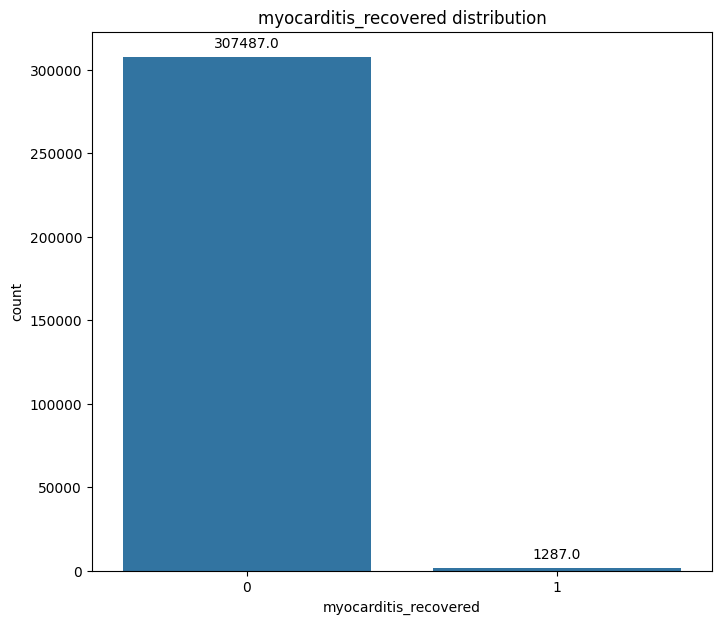

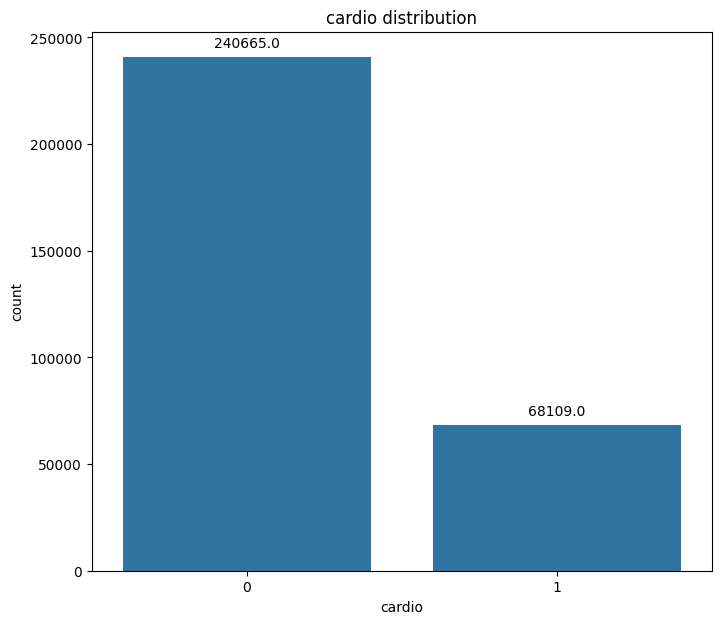

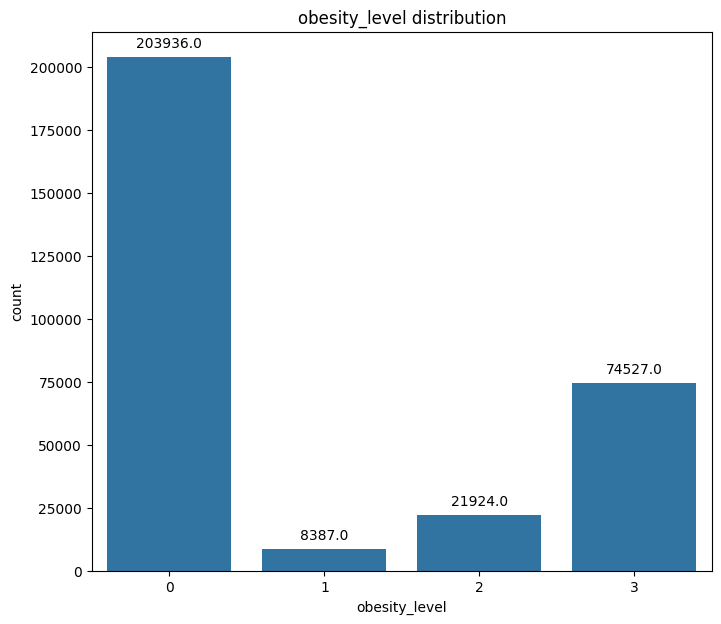

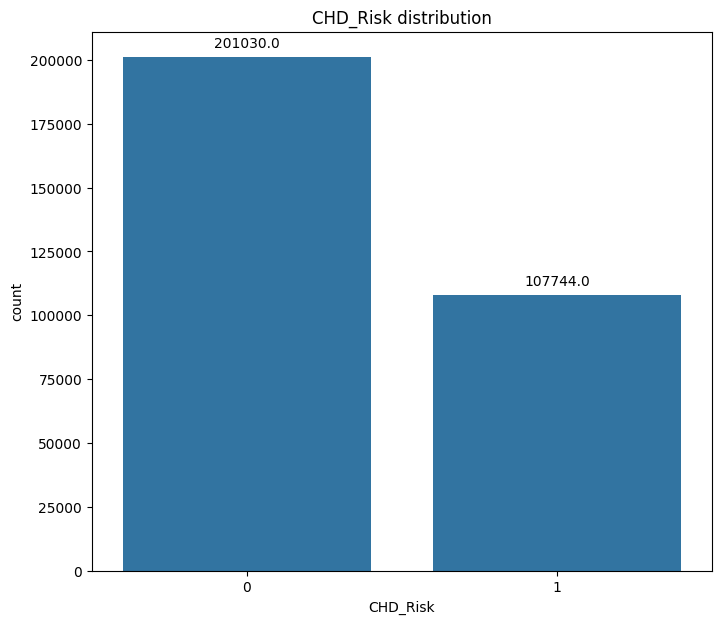

In [18]:
# Chart 2 - visualization code
for i in categorical_var:
  plt.figure(figsize=(8,7))
  p = sns.countplot(x=i, data = df)
  plt.xlabel(i)
  plt.title(i+' distribution')
  for i in p.patches:
    p.annotate(f'{i.get_height()}', (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
  plt.show()

### Relationship between the dependent variable and continuous independent variables


<Figure size 1000x500 with 0 Axes>

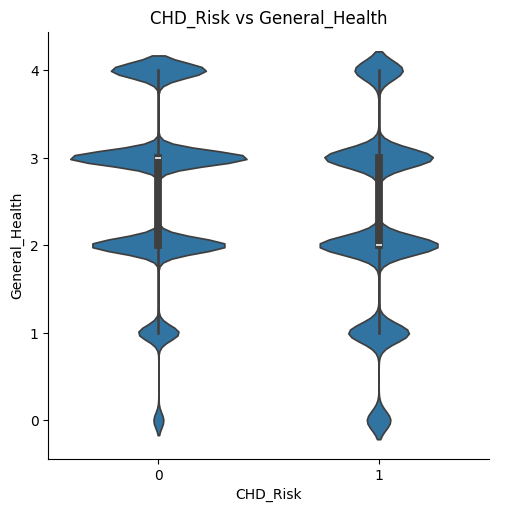

<Figure size 1000x500 with 0 Axes>

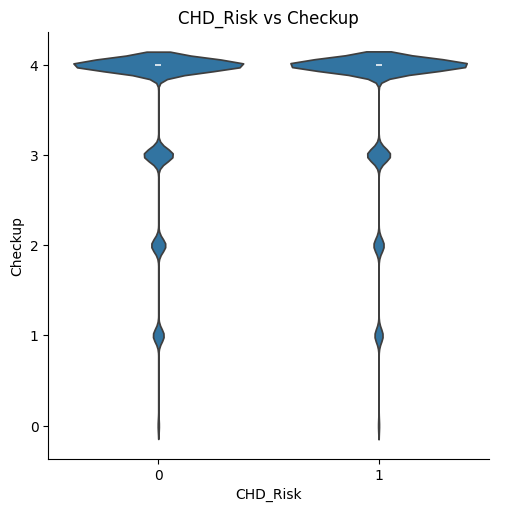

<Figure size 1000x500 with 0 Axes>

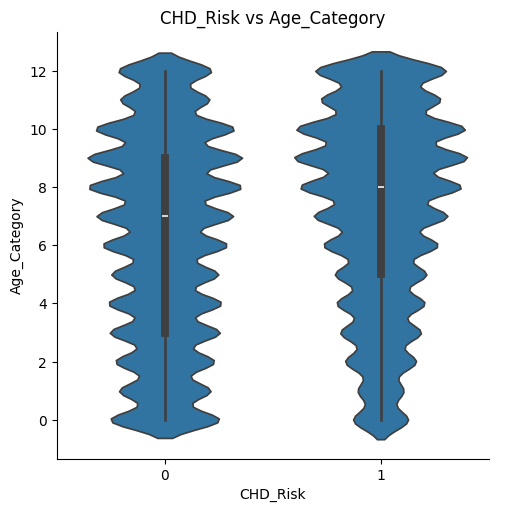

<Figure size 1000x500 with 0 Axes>

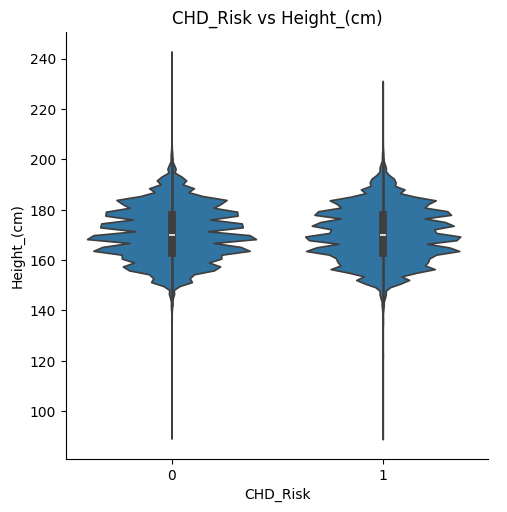

<Figure size 1000x500 with 0 Axes>

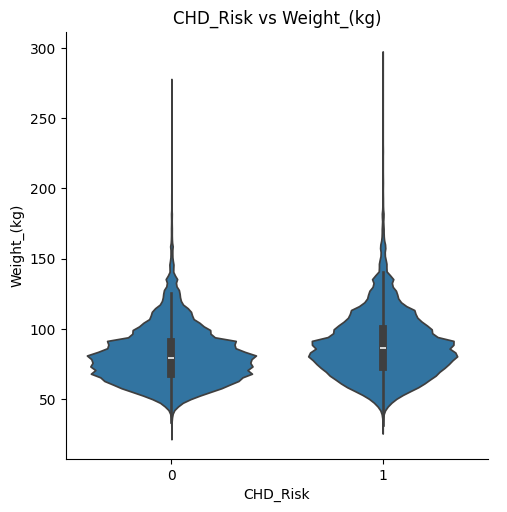

<Figure size 1000x500 with 0 Axes>

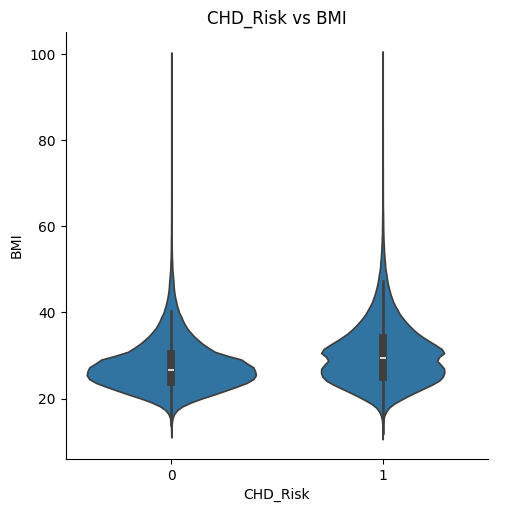

<Figure size 1000x500 with 0 Axes>

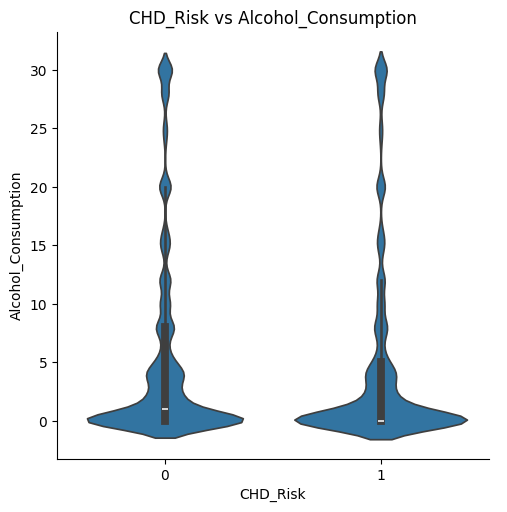

<Figure size 1000x500 with 0 Axes>

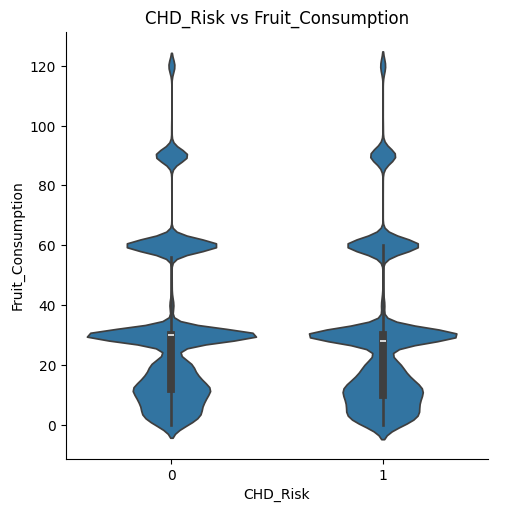

<Figure size 1000x500 with 0 Axes>

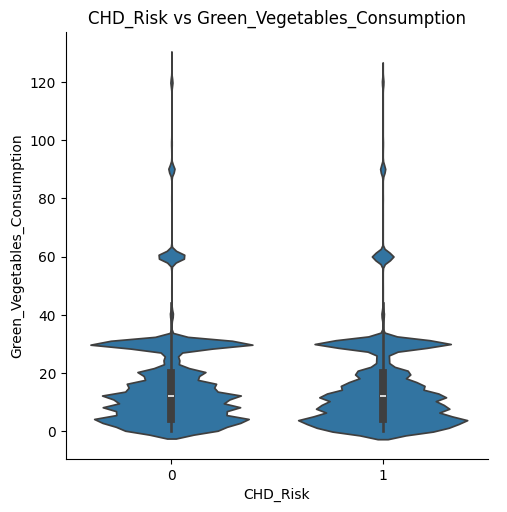

<Figure size 1000x500 with 0 Axes>

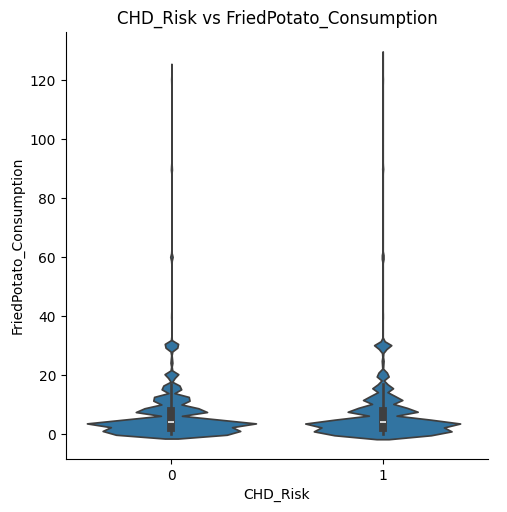

<Figure size 1000x500 with 0 Axes>

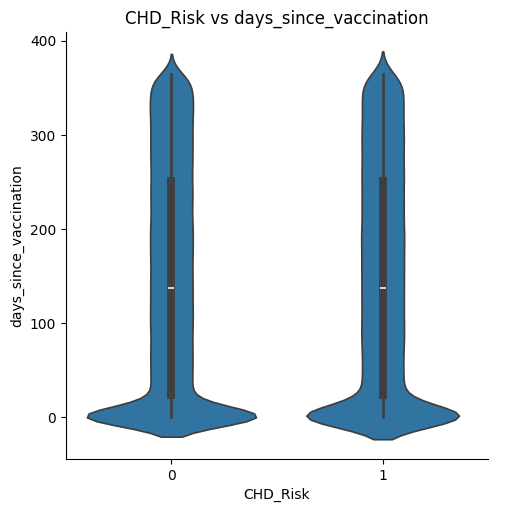

In [19]:
# Chart - 4 visualization code
for i in continuous_var:
  plt.figure(figsize=(10,5))
  sns.catplot(x=dependent_var[0],y=i,data=df,kind='violin')
  plt.ylabel(i)
  plt.xlabel(dependent_var[0])
  plt.title(dependent_var[0]+' vs '+i)
  plt.show()

<Figure size 1000x500 with 0 Axes>

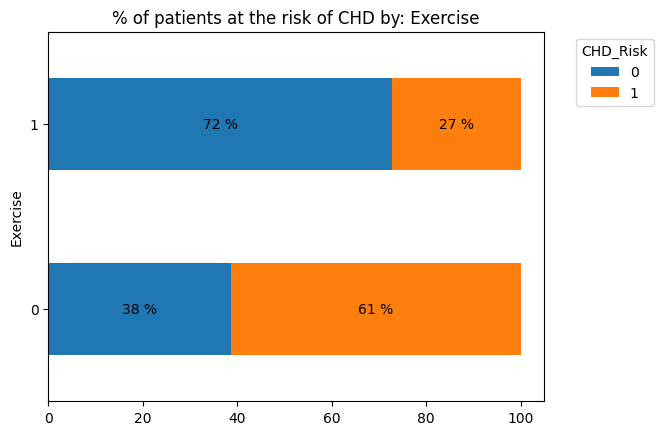

<Figure size 1000x500 with 0 Axes>

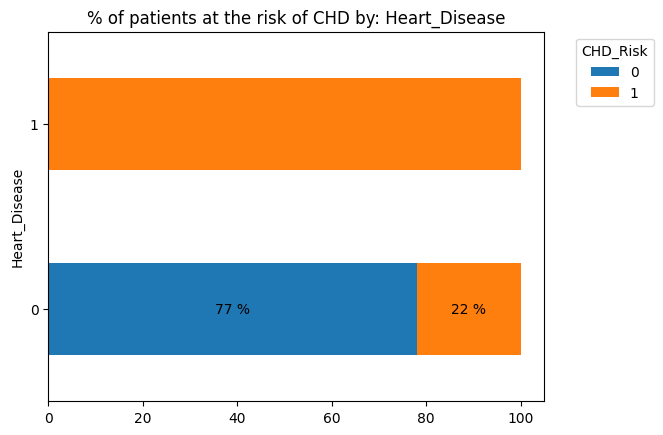

<Figure size 1000x500 with 0 Axes>

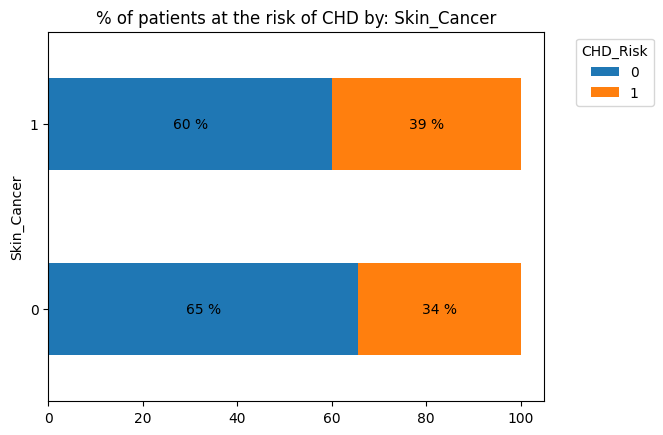

<Figure size 1000x500 with 0 Axes>

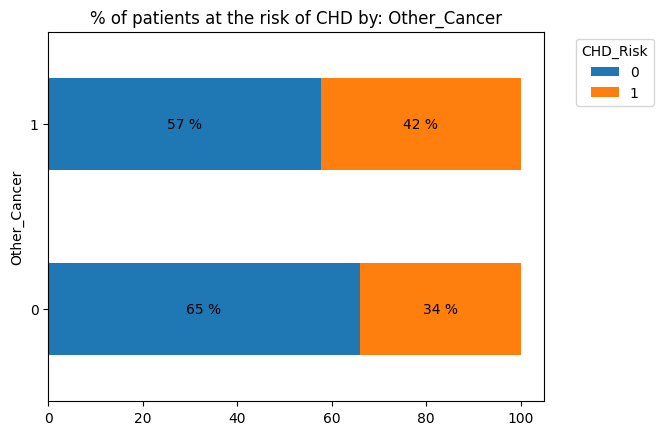

<Figure size 1000x500 with 0 Axes>

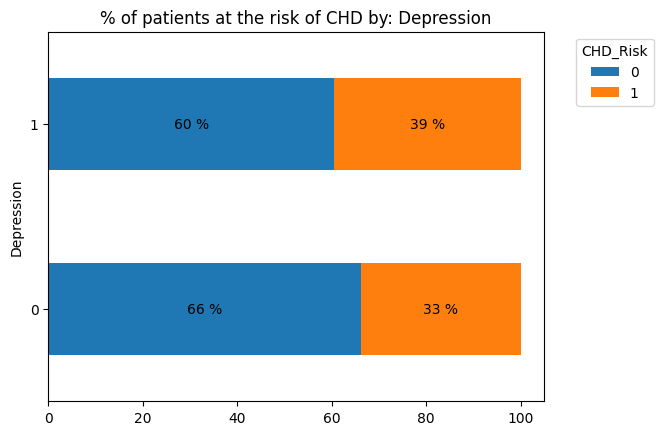

<Figure size 1000x500 with 0 Axes>

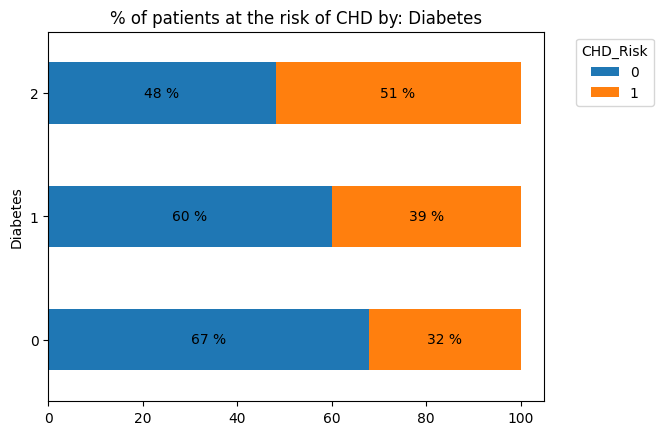

<Figure size 1000x500 with 0 Axes>

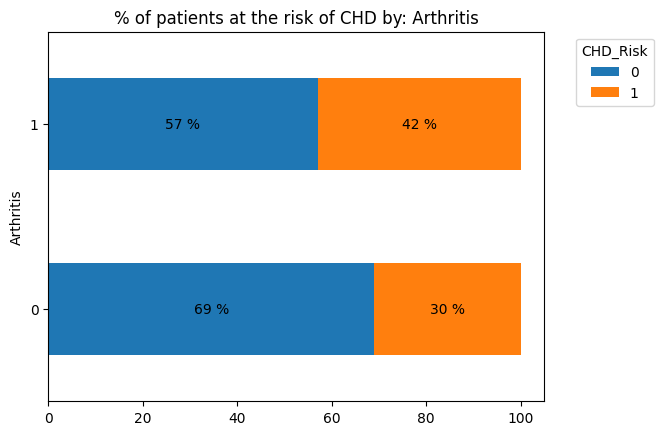

<Figure size 1000x500 with 0 Axes>

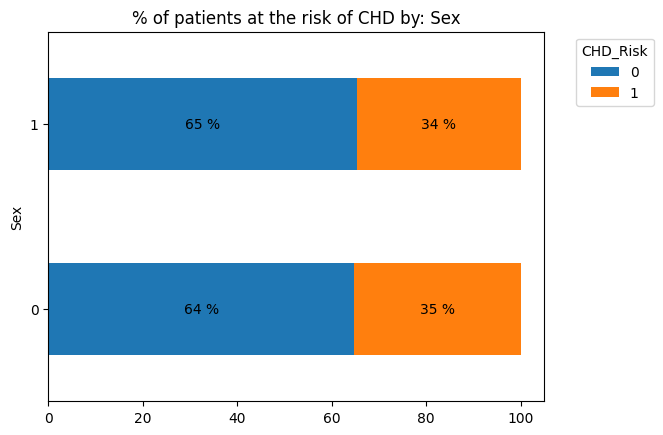

<Figure size 1000x500 with 0 Axes>

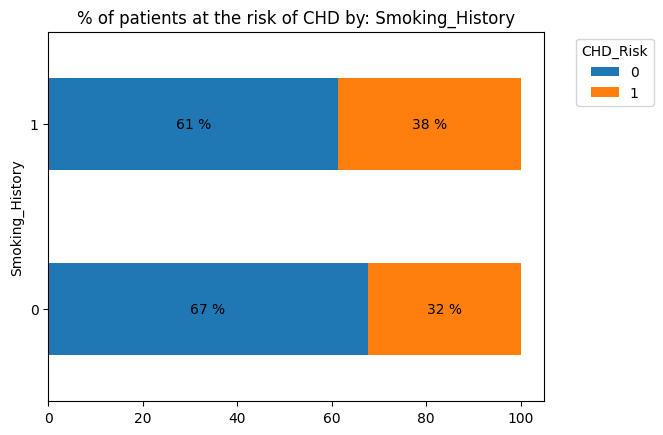

<Figure size 1000x500 with 0 Axes>

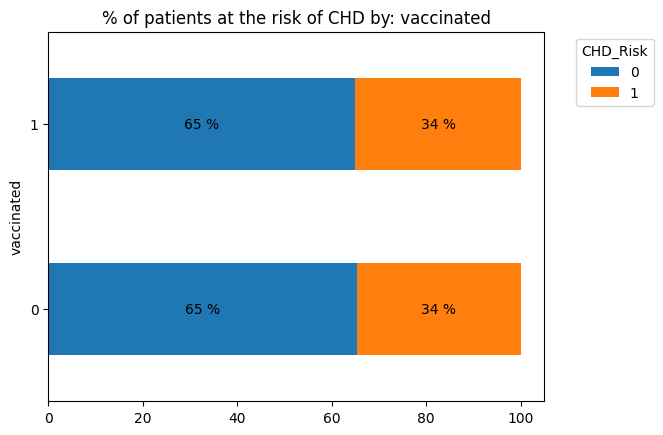

<Figure size 1000x500 with 0 Axes>

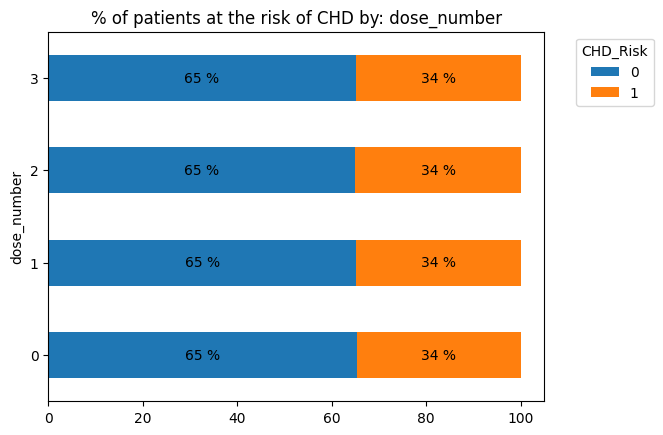

<Figure size 1000x500 with 0 Axes>

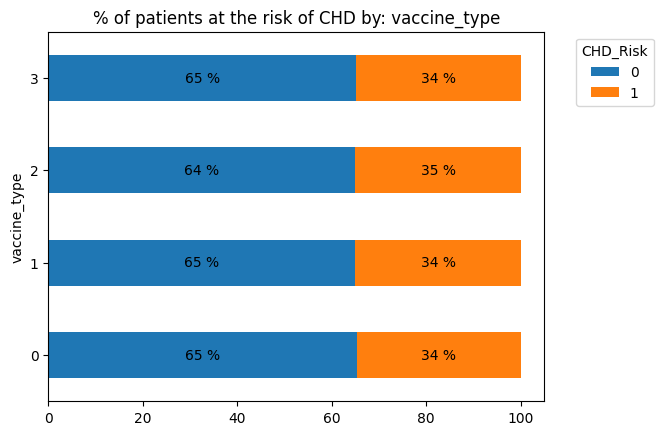

<Figure size 1000x500 with 0 Axes>

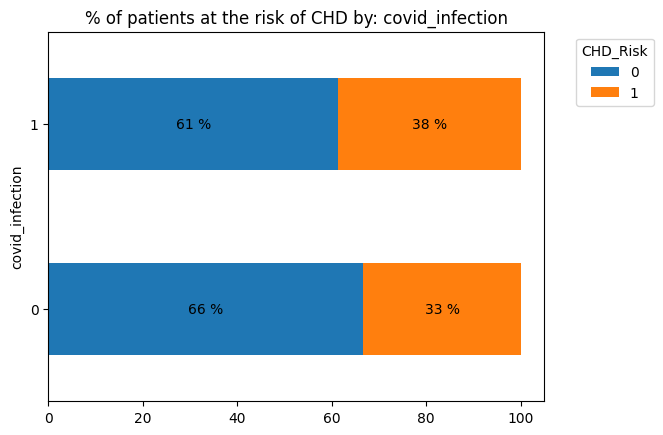

<Figure size 1000x500 with 0 Axes>

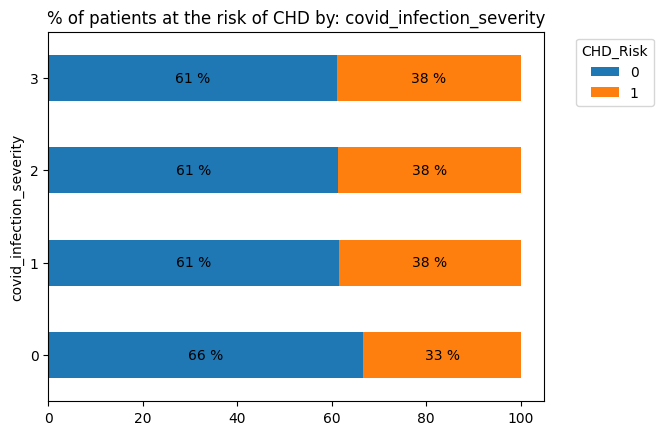

<Figure size 1000x500 with 0 Axes>

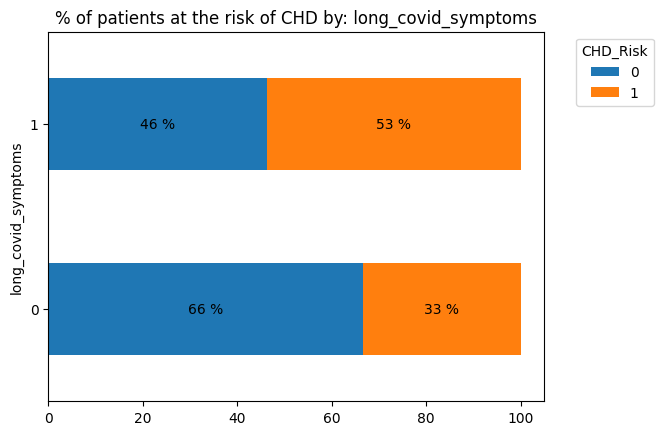

<Figure size 1000x500 with 0 Axes>

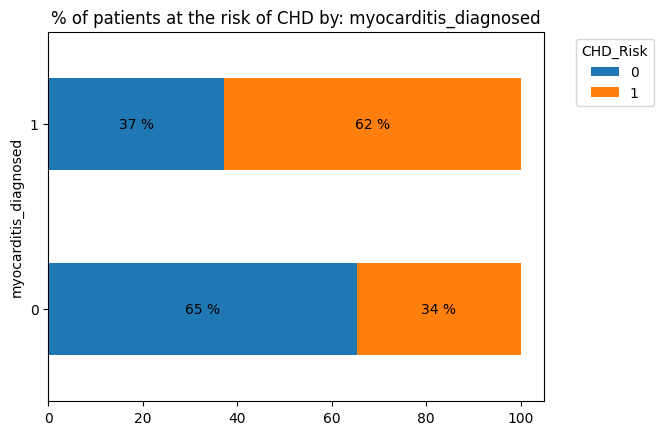

<Figure size 1000x500 with 0 Axes>

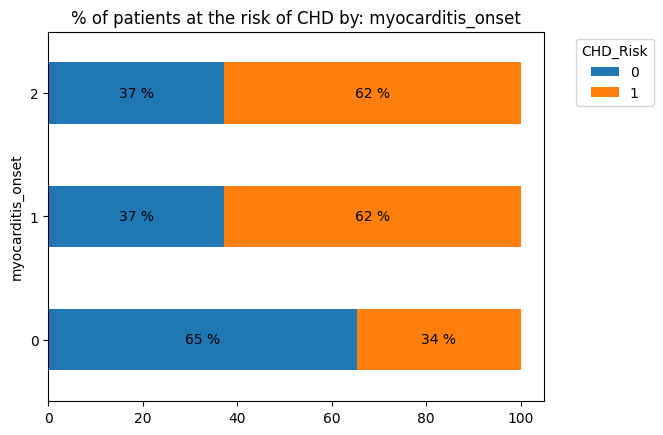

<Figure size 1000x500 with 0 Axes>

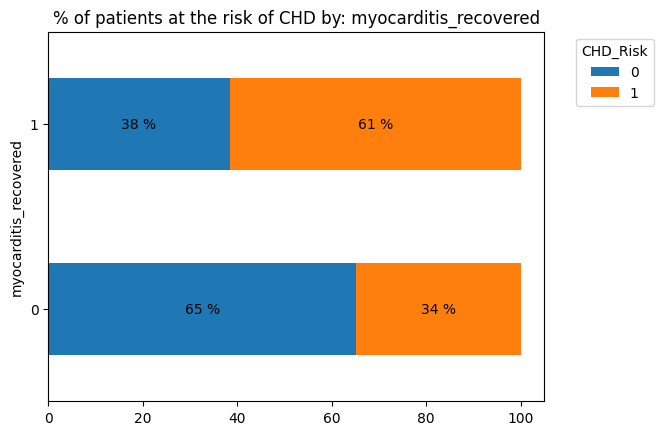

<Figure size 1000x500 with 0 Axes>

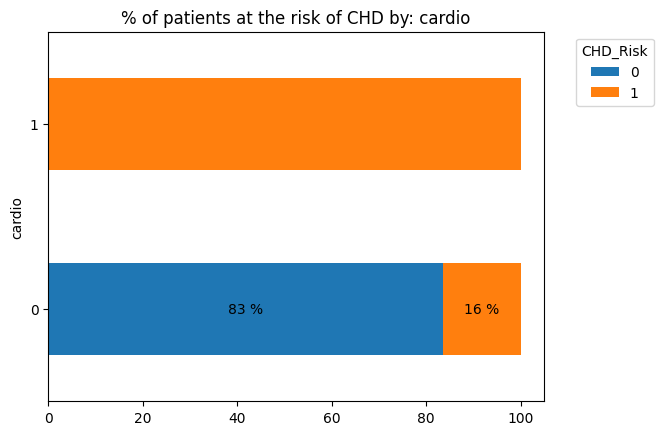

<Figure size 1000x500 with 0 Axes>

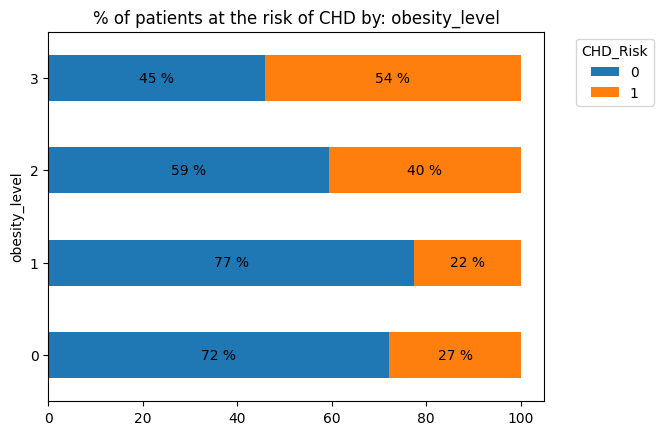

In [20]:
# Chart - 5 visualization code
# 100% stacked bar chart

for i in categorical_var[:-1]:
    x_var, y_var = i, dependent_var[0]
    plt.figure(figsize=(10,5))
    df_grouped = df.groupby(x_var)[y_var].value_counts(normalize=True).unstack(y_var)*100
    df_grouped.plot.barh(stacked=True)
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        title=y_var)

    plt.title("% of patients at the risk of CHD by: "+i)
    for ix, row in df_grouped.reset_index(drop=True).iterrows():
        # print(ix, row)
        cumulative = 0
        for element in row:
            if element > 0.1:
                plt.text(
                    cumulative + element / 2,
                    ix,
                    f"{int(element)} %",
                    va="center",
                    ha="center",
                )
            cumulative += element
    plt.show()

In [21]:
numeric_cols =['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 
               'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 
               'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 
               'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption',
                 'vaccinated', 'dose_number', 'vaccine_type', 'days_since_vaccination', 'covid_infection',
                   'covid_infection_severity', 'long_covid_symptoms', 'myocarditis_diagnosed', 'myocarditis_onset', 
                   'myocarditis_recovered', 'cardio', 'CHD_Risk', 'obesity_level']

# Ensure only valid numeric columns
numeric_cols_cleaned = [col for col in numeric_cols if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

# Split features and target
X = df.drop(columns=['CHD_Risk','Heart_Disease', 'myocarditis_diagnosed', 'myocarditis_onset','cardio','Height_(cm)', 
                     'Weight_(kg)', 'covid_infection_severity','covid_infection'])
y = df['CHD_Risk']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [22]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("Number of features after scaling:", X_train_scaled.shape[1])
print("Number of training samples:", X_train_scaled.shape[0])
print("Number of testing samples:", X_test_scaled.shape[0])
print(df.isnull().sum().sum())


X_train_scaled shape: (247019, 23)
X_test_scaled shape: (61755, 23)
Number of features after scaling: 23
Number of training samples: 247019
Number of testing samples: 61755
0


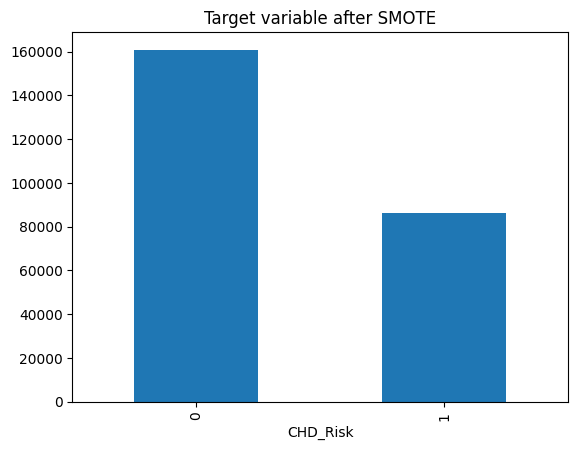

CHD_Risk
0    160824
1     86195
Name: count, dtype: int64


In [23]:
y_train.value_counts().plot(kind='bar', title='Target variable after SMOTE')
plt.show()
print(y_train.value_counts())

The dataset is imbalanced and the number of positive cases is very low compared to the negative cases. SMOTE works by generating synthetic samples from the minority class to balance the class distribution. It does this by selecting instances that are close in the feature space and drawing a line between them, then creating new instances along this line. 

Samples in the original dataset:  247019
Samples in the resampled dataset:  306836
Samples in the original dataset:  247019
Samples in the resampled dataset:  306836


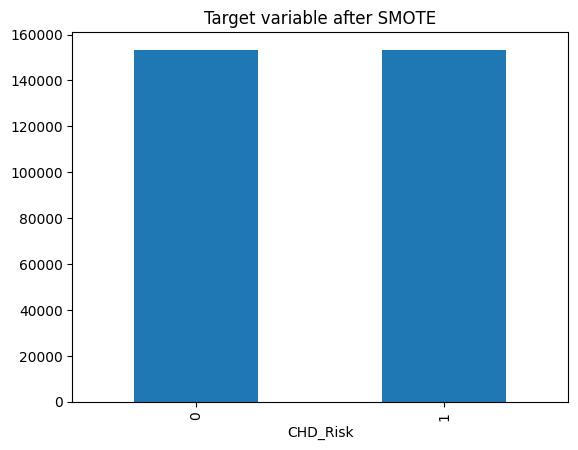

In [24]:
from imblearn.combine import SMOTETomek

X_smote, y_smote = SMOTETomek(random_state=0).fit_resample(X_train_scaled, y_train)

print('Samples in the original dataset: ', len(y_train))
print('Samples in the resampled dataset: ', len(y_smote))
print('Samples in the original dataset: ', len(X_train))
print('Samples in the resampled dataset: ', len(X_smote))

y_smote.value_counts().plot(kind='bar', title='Target variable after SMOTE')
plt.show()




In [25]:
# Save processed datasets
X_train.to_csv(r'C:\Users\megha\Downloads\project1\data\X_train_processed.csv', index=False)
X_test.to_csv(r'C:\Users\megha\Downloads\project1\data\X_test_processed.csv', index=False)
y_train.to_csv(r'C:\Users\megha\Downloads\project1\data\y_train.csv', index=False)
y_test.to_csv(r'C:\Users\megha\Downloads\project1\data\y_test.csv', index=False)

In [26]:
X.to_csv(r'C:\Users\megha\Downloads\project1\data\X.csv', index=False)